<a href="https://colab.research.google.com/github/LordRelentless/Innocentive-RUL-Nth-Mathematics-/blob/main/Innocentive_RUL_Nth_Mathematics_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

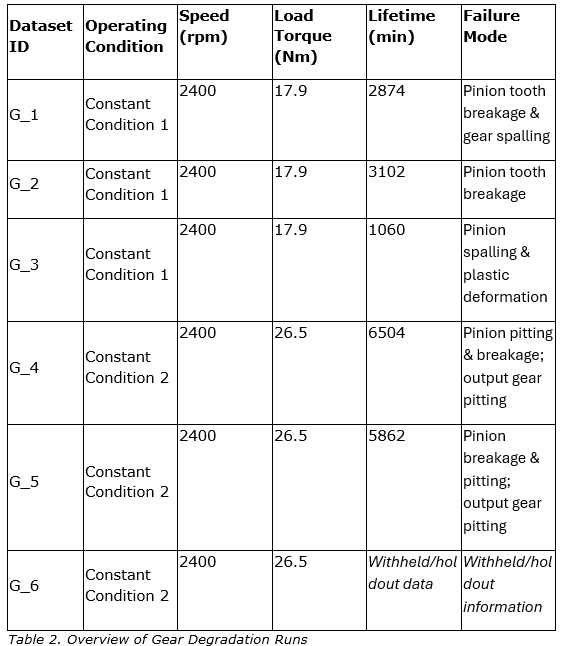
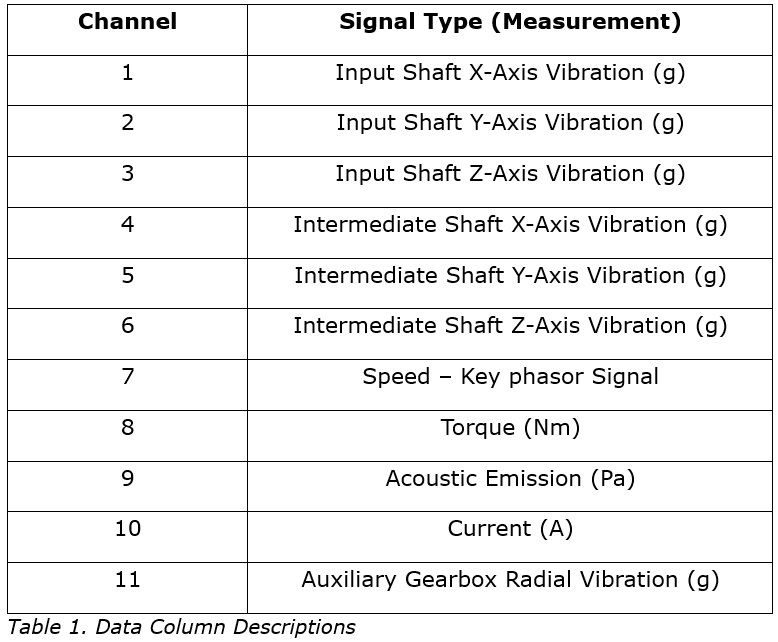

G1: Pinion Tooth Breakage and Gear Spawling; Speed RPM 2400, Torque: 17.9 Lifetime 2874 Minutes

G1 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+5.120463e-07 per rev, R^2=0.459
Channel 2 (β): slope=+1.587085e-07 per rev, R^2=0.147
Channel 3 (γ): slope=+8.361115e-07 per rev, R^2=0.611
Channel 4 (δ): slope=+6.245101e-07 per rev, R^2=0.446
Channel 5 (ε): slope=+6.492190e-07 per rev, R^2=0.483
Channel 6 (ζ): slope=-1.286593e-07 per rev, R^2=0.063
Channel 7 (η): slope=+4.172171e-07 per rev, R^2=0.036
Channel 8 (θ): slope=+2.619207e-07 per rev, R^2=0.142
Channel 9 (ι): slope=+2.304449e-07 per rev, R^2=0.009
Channel 10 (κ): slope=-1.895115e-07 per rev, R^2=0.022
Channel 11 (λ): slope=+7.201089e-08 per rev, R^2=0.029


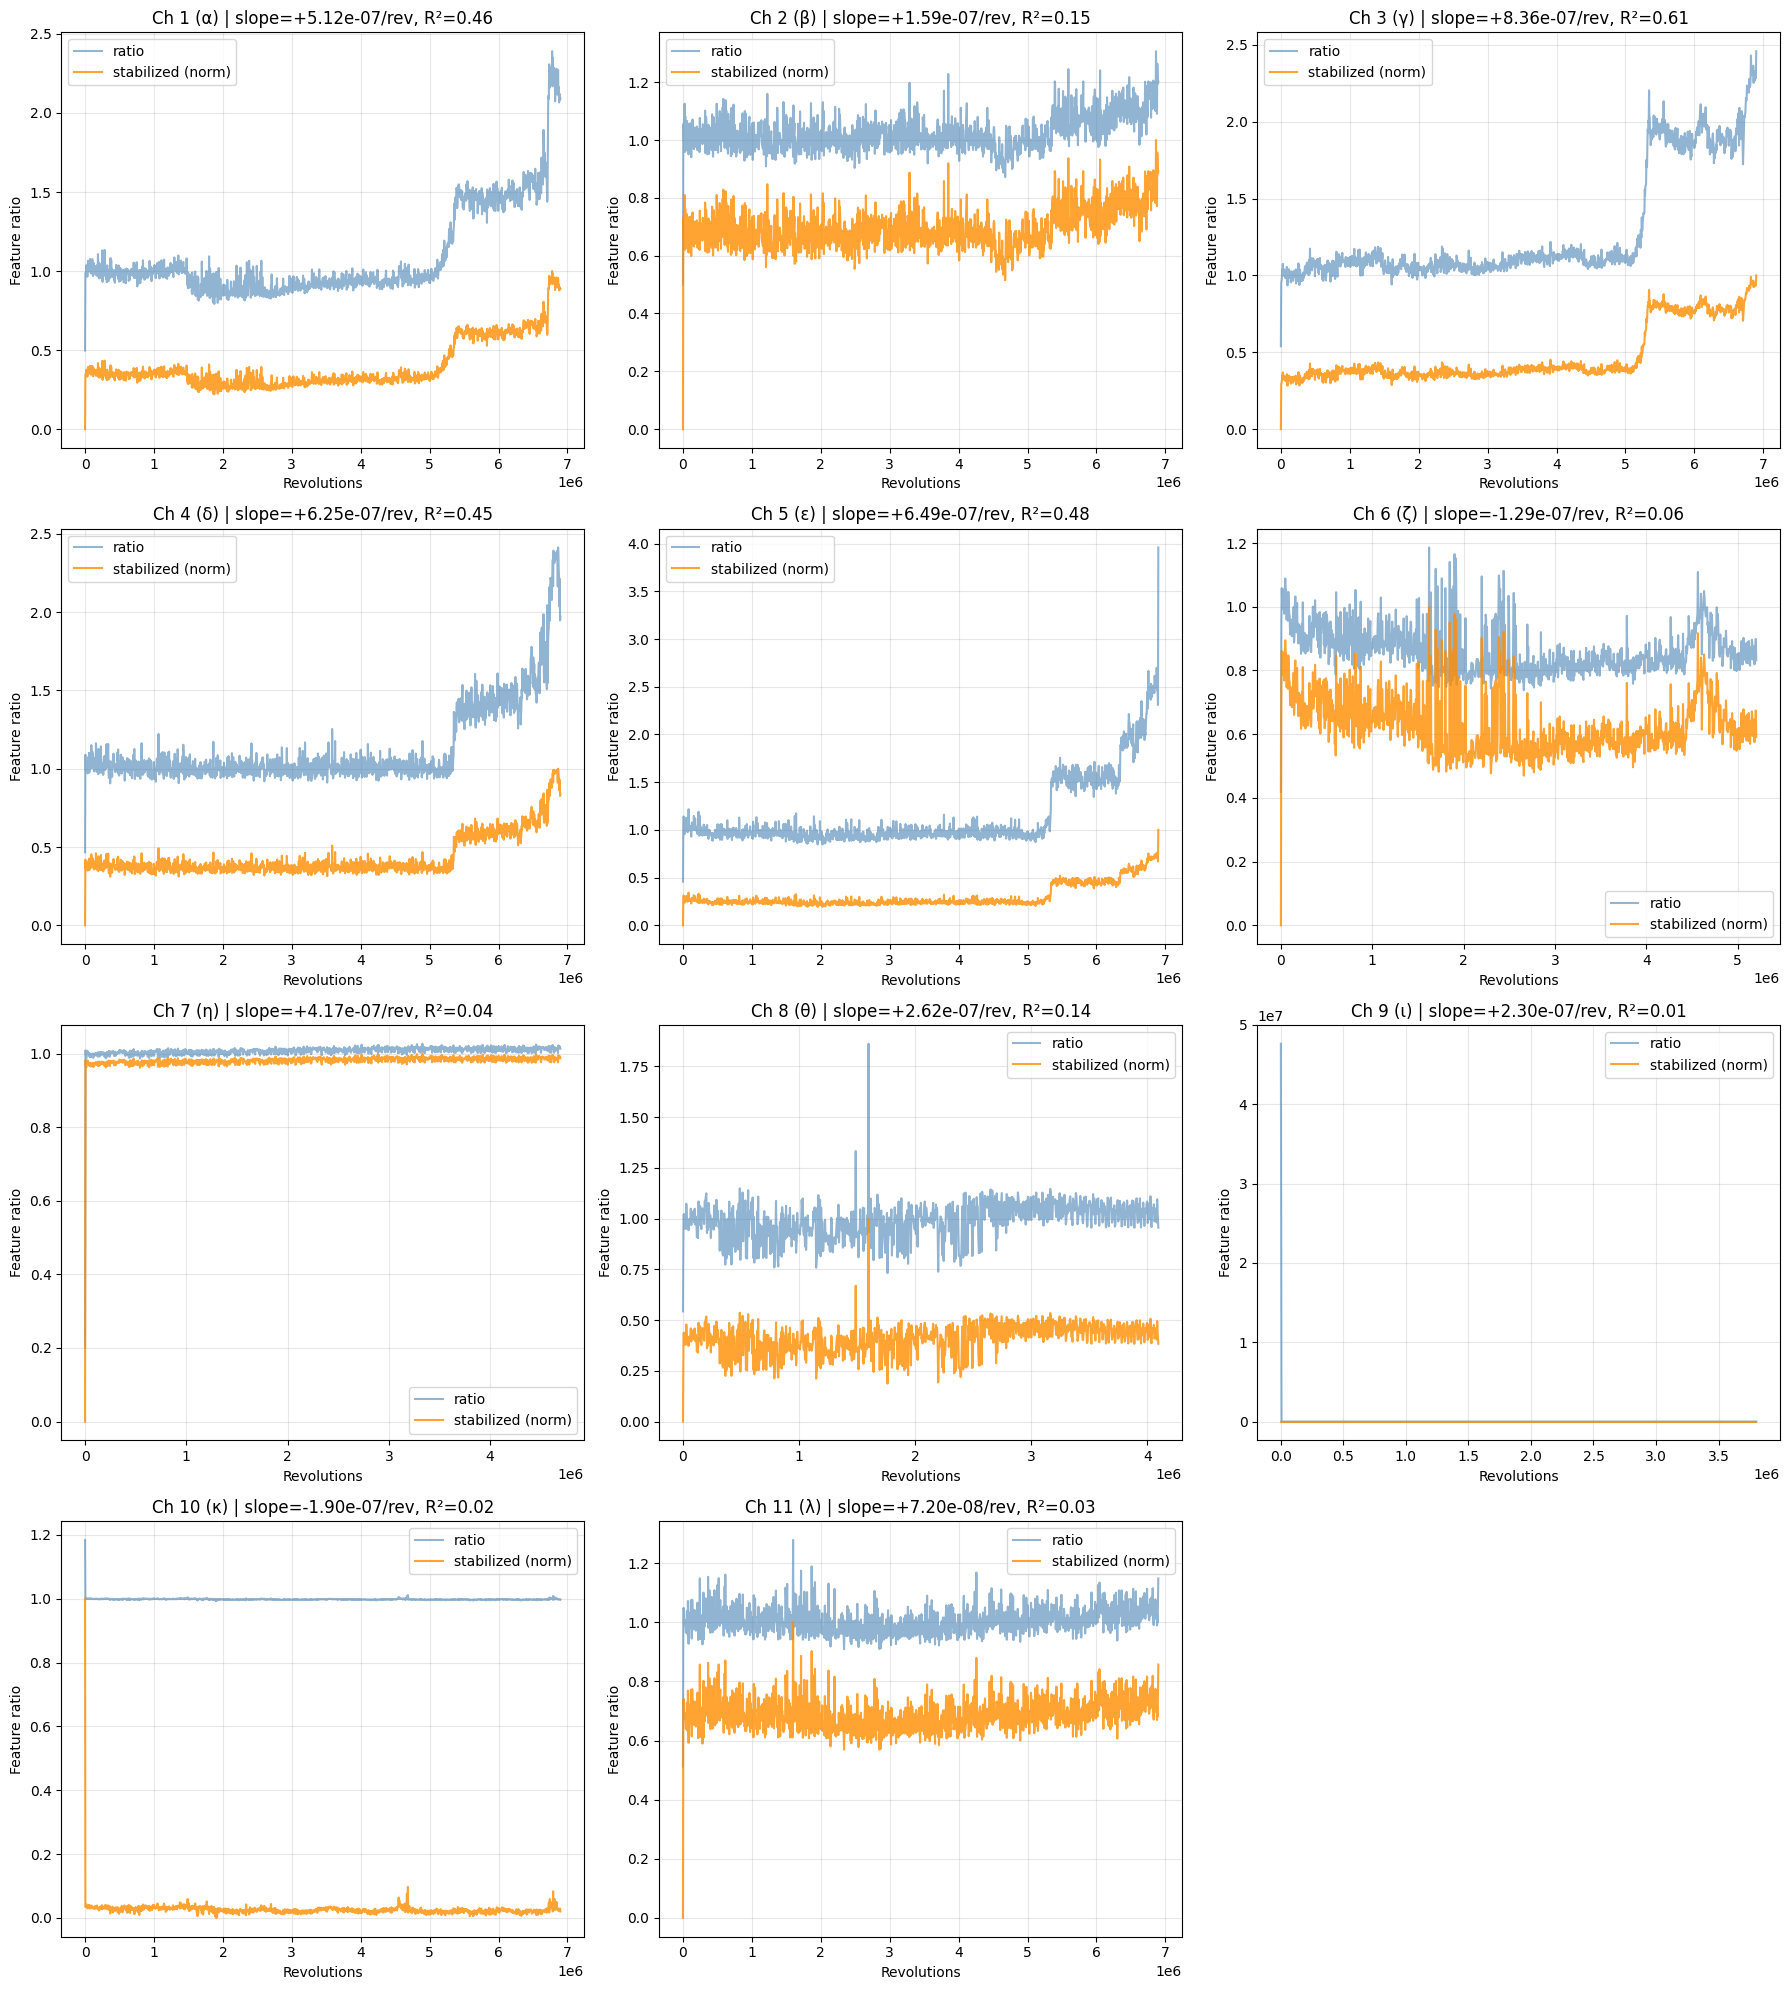

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G1'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G2: Pinion tooth breakage, RPM 2400, Torque 17.9, Lifetime 3102

G2 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=-1.980070e-07 per rev, R^2=0.229
Channel 2 (β): slope=+1.786235e-07 per rev, R^2=0.269
Channel 3 (γ): slope=+3.674397e-07 per rev, R^2=0.576
Channel 4 (δ): slope=+3.469483e-07 per rev, R^2=0.363
Channel 5 (ε): slope=+3.666210e-07 per rev, R^2=0.347
Channel 6 (ζ): slope=+3.162227e-07 per rev, R^2=0.324
Channel 7 (η): slope=-2.302774e-07 per rev, R^2=0.092
Channel 8 (θ): slope=+6.259584e-08 per rev, R^2=0.033
Channel 9 (ι): slope=+2.807042e-07 per rev, R^2=0.009
Channel 10 (κ): slope=+6.150729e-08 per rev, R^2=0.011


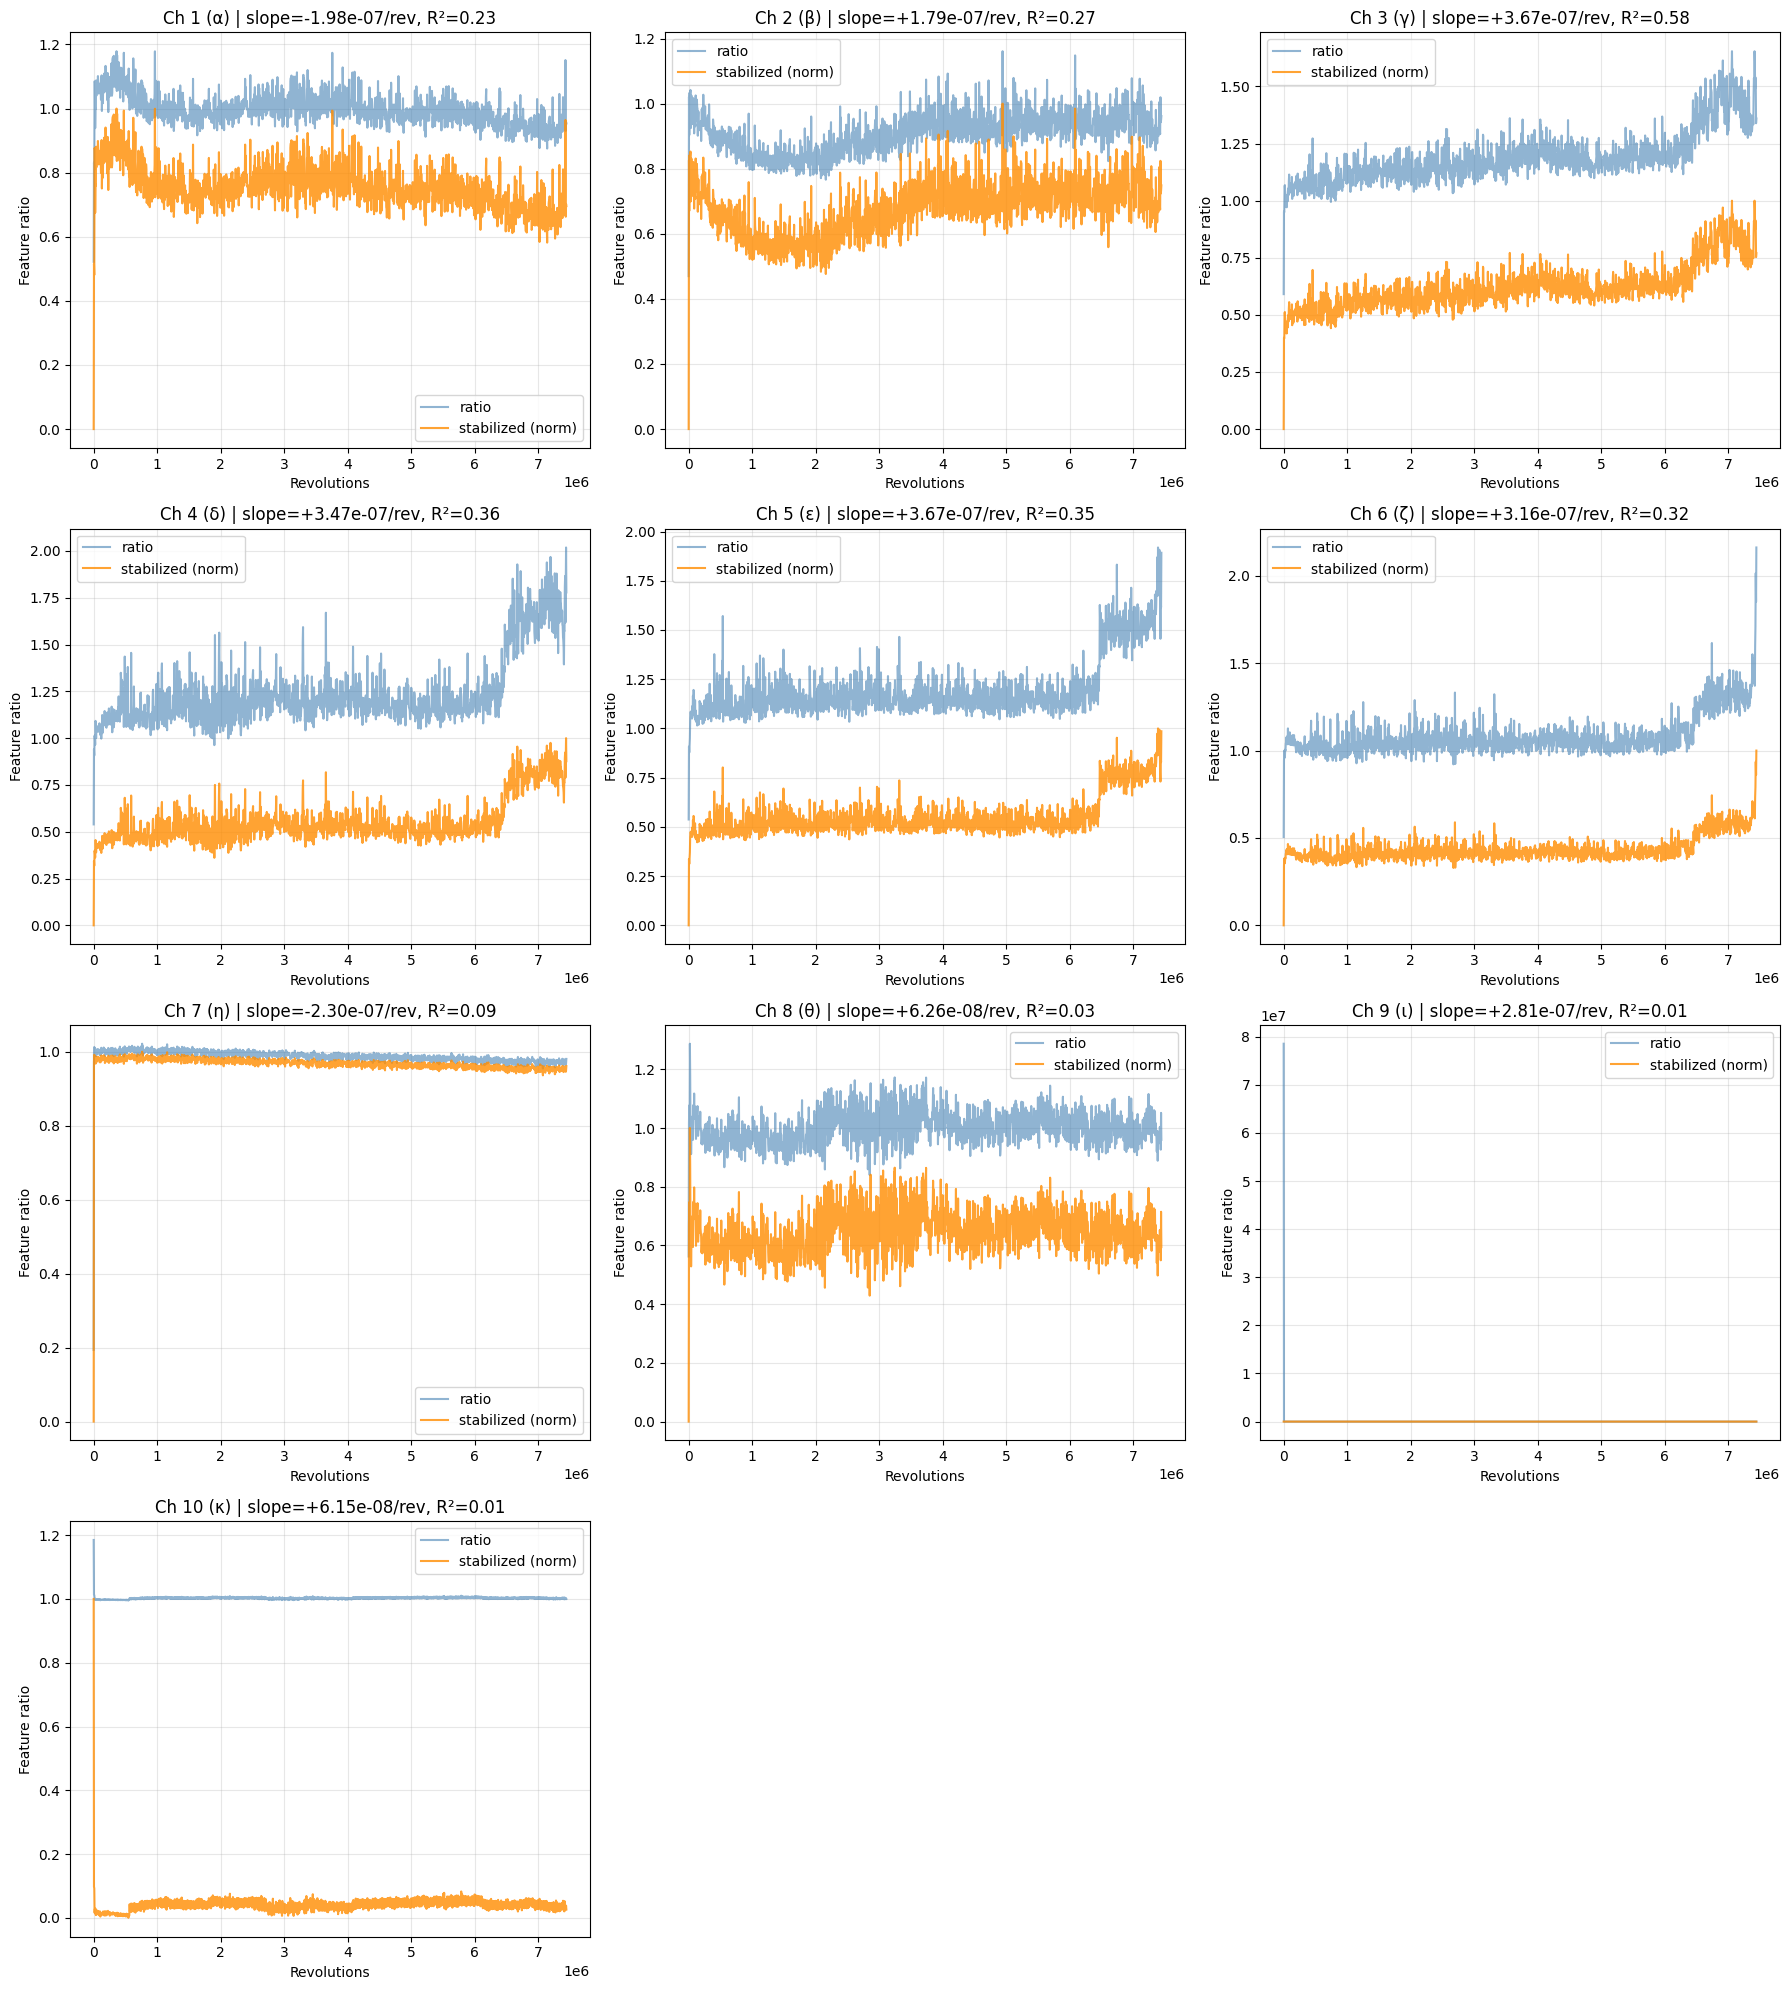

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G2'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G3: Pinion Spawling and Plastic Deformation; RPM 2400, Torque 17.9, Lifetime 1060

G3 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+4.322272e-07 per rev, R^2=0.153
Channel 2 (β): slope=+6.696034e-07 per rev, R^2=0.353
Channel 3 (γ): slope=+4.902331e-07 per rev, R^2=0.366
Channel 4 (δ): slope=+1.071476e-06 per rev, R^2=0.324
Channel 5 (ε): slope=+7.463214e-07 per rev, R^2=0.636
Channel 6 (ζ): slope=+9.648081e-07 per rev, R^2=0.597
Channel 7 (η): slope=+1.027362e-06 per rev, R^2=0.091
Channel 8 (θ): slope=-7.964688e-07 per rev, R^2=0.333
Channel 9 (ι): slope=+7.271066e-07 per rev, R^2=0.028
Channel 10 (κ): slope=+1.231692e-09 per rev, R^2=0.000


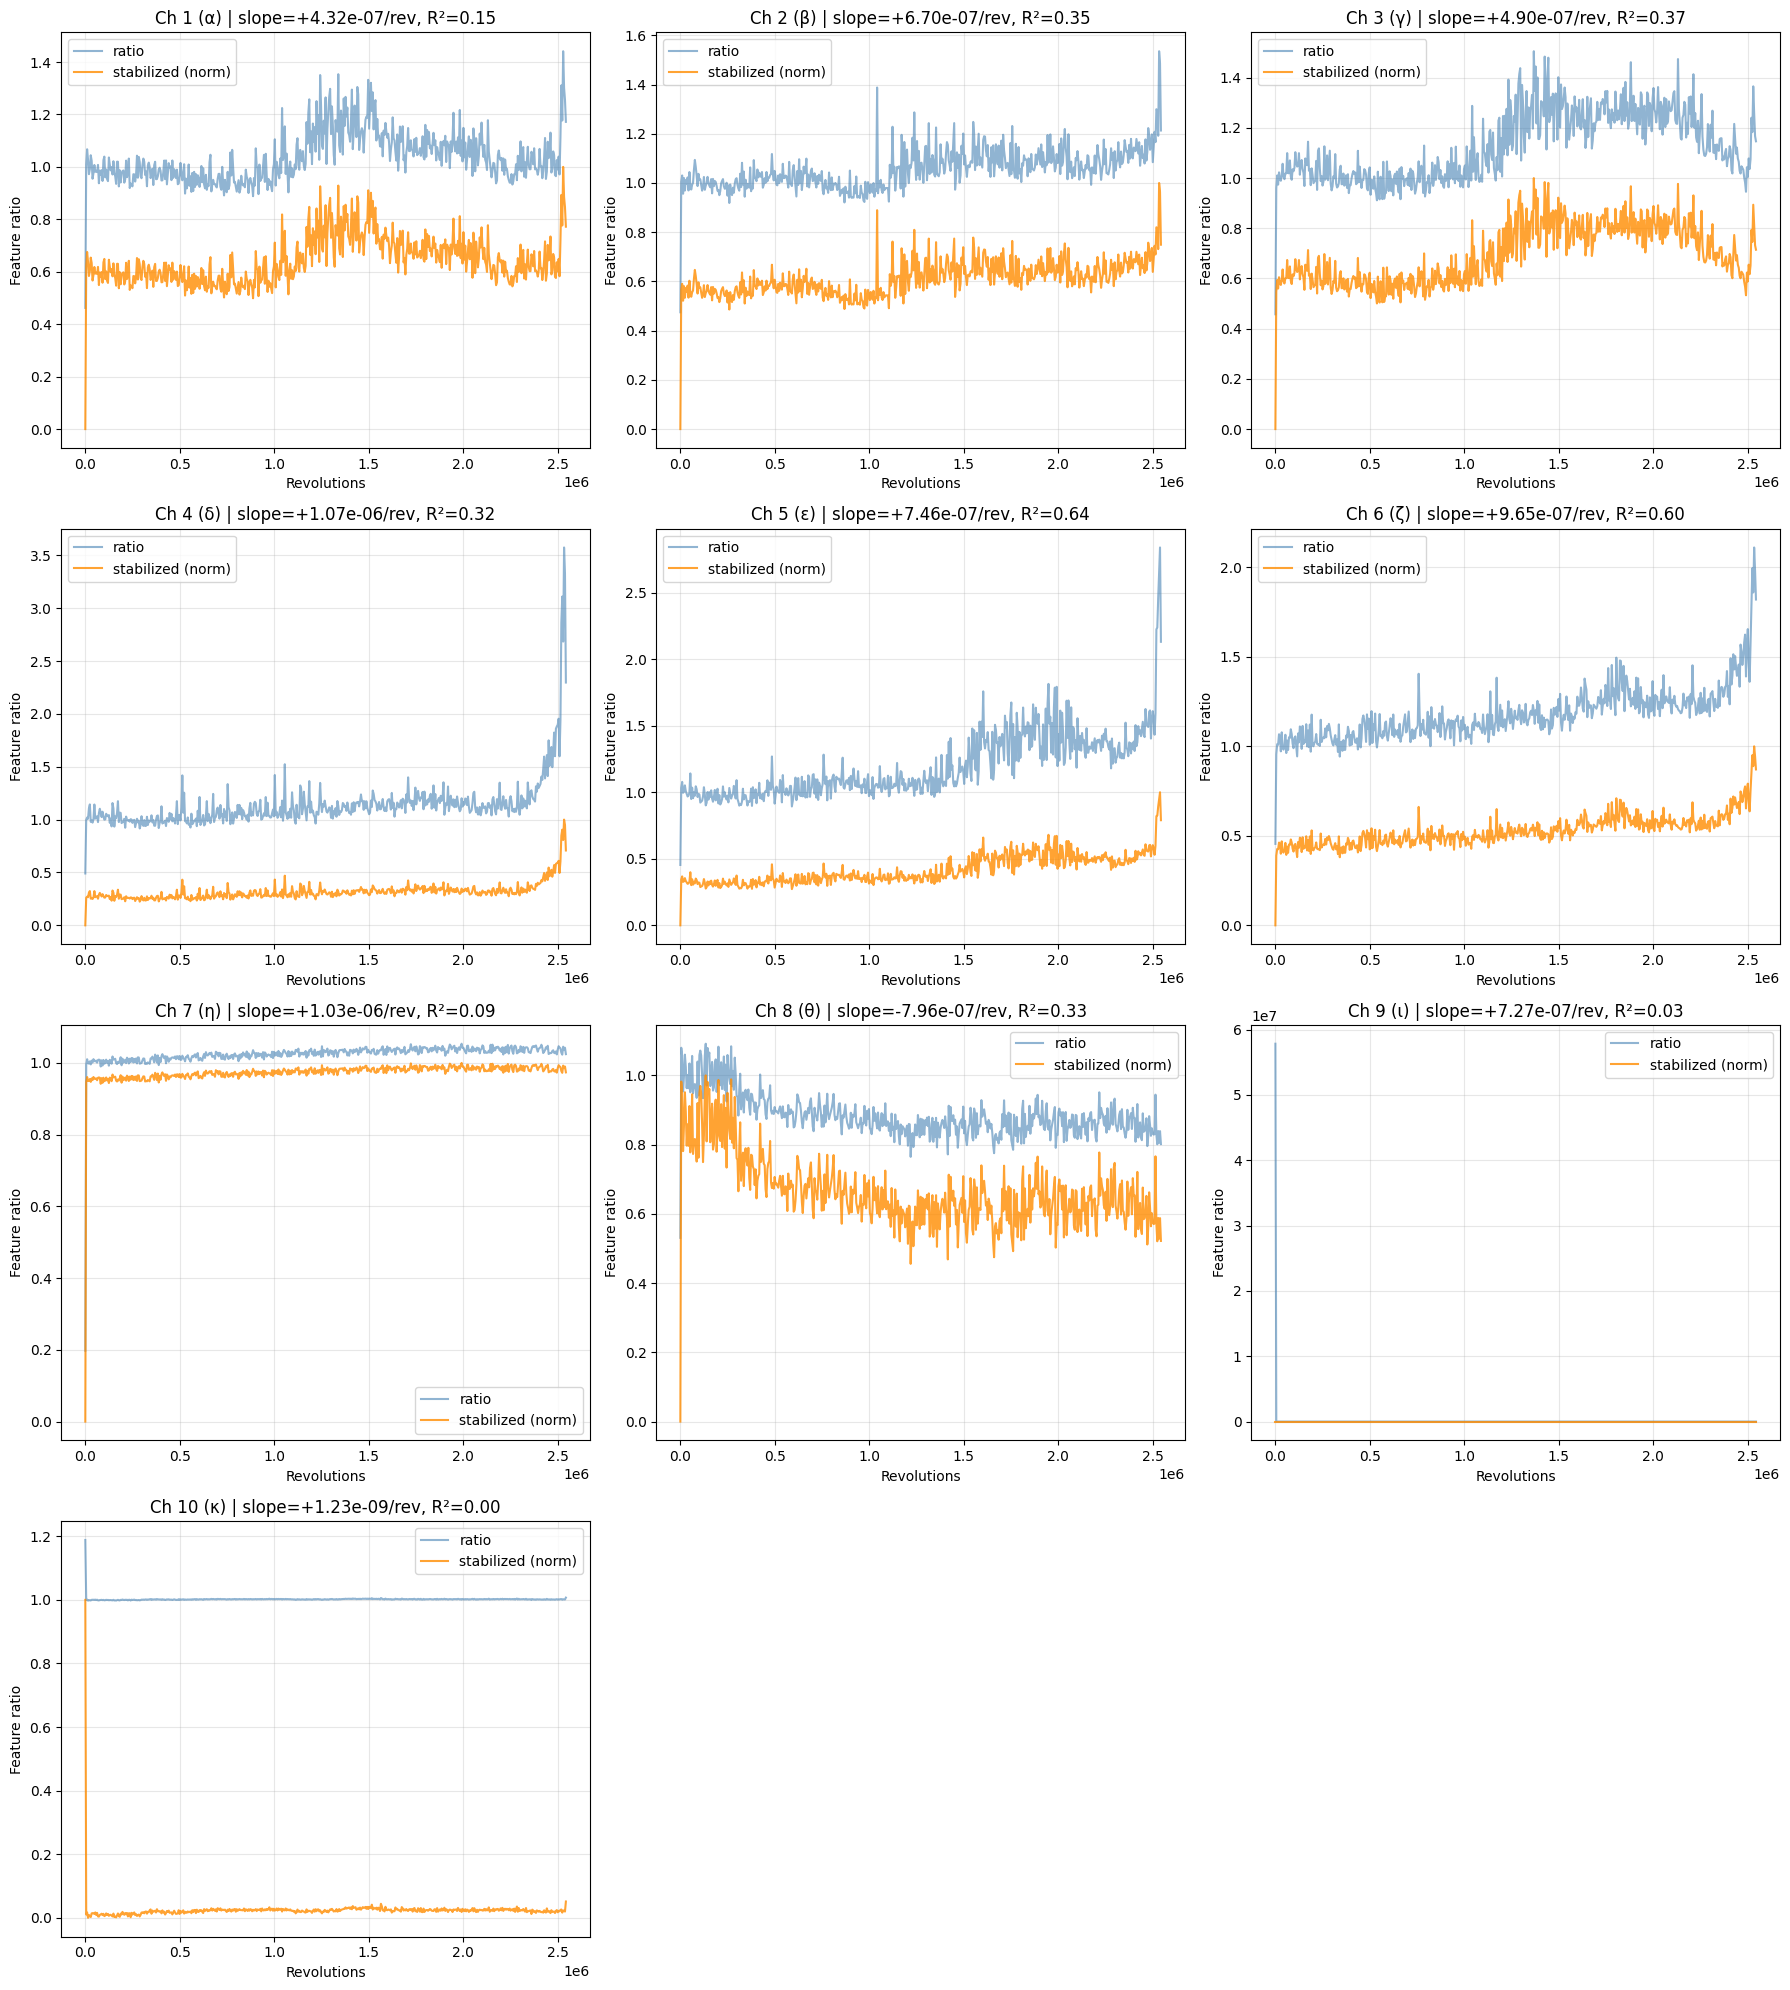

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G3'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G4: Pinion pitting and breakage, output gear breakage; RPM 2400, Torque 26.5, lifetime 6504

G4 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+6.200782e-07 per rev, R^2=0.314
Channel 2 (β): slope=+9.702338e-09 per rev, R^2=0.002
Channel 3 (γ): slope=+1.950716e-07 per rev, R^2=0.165
Channel 4 (δ): slope=+4.621738e-07 per rev, R^2=0.263
Channel 5 (ε): slope=+2.649814e-07 per rev, R^2=0.327
Channel 6 (ζ): slope=+2.247787e-07 per rev, R^2=0.349
Channel 7 (η): slope=+1.283963e-07 per rev, R^2=0.808
Channel 8 (θ): slope=+1.254513e-06 per rev, R^2=0.373
Channel 9 (ι): slope=+1.353899e-07 per rev, R^2=0.137
Channel 10 (κ): slope=-1.853731e-08 per rev, R^2=0.001
Channel 11 (λ): slope=-4.026023e-09 per rev, R^2=0.001


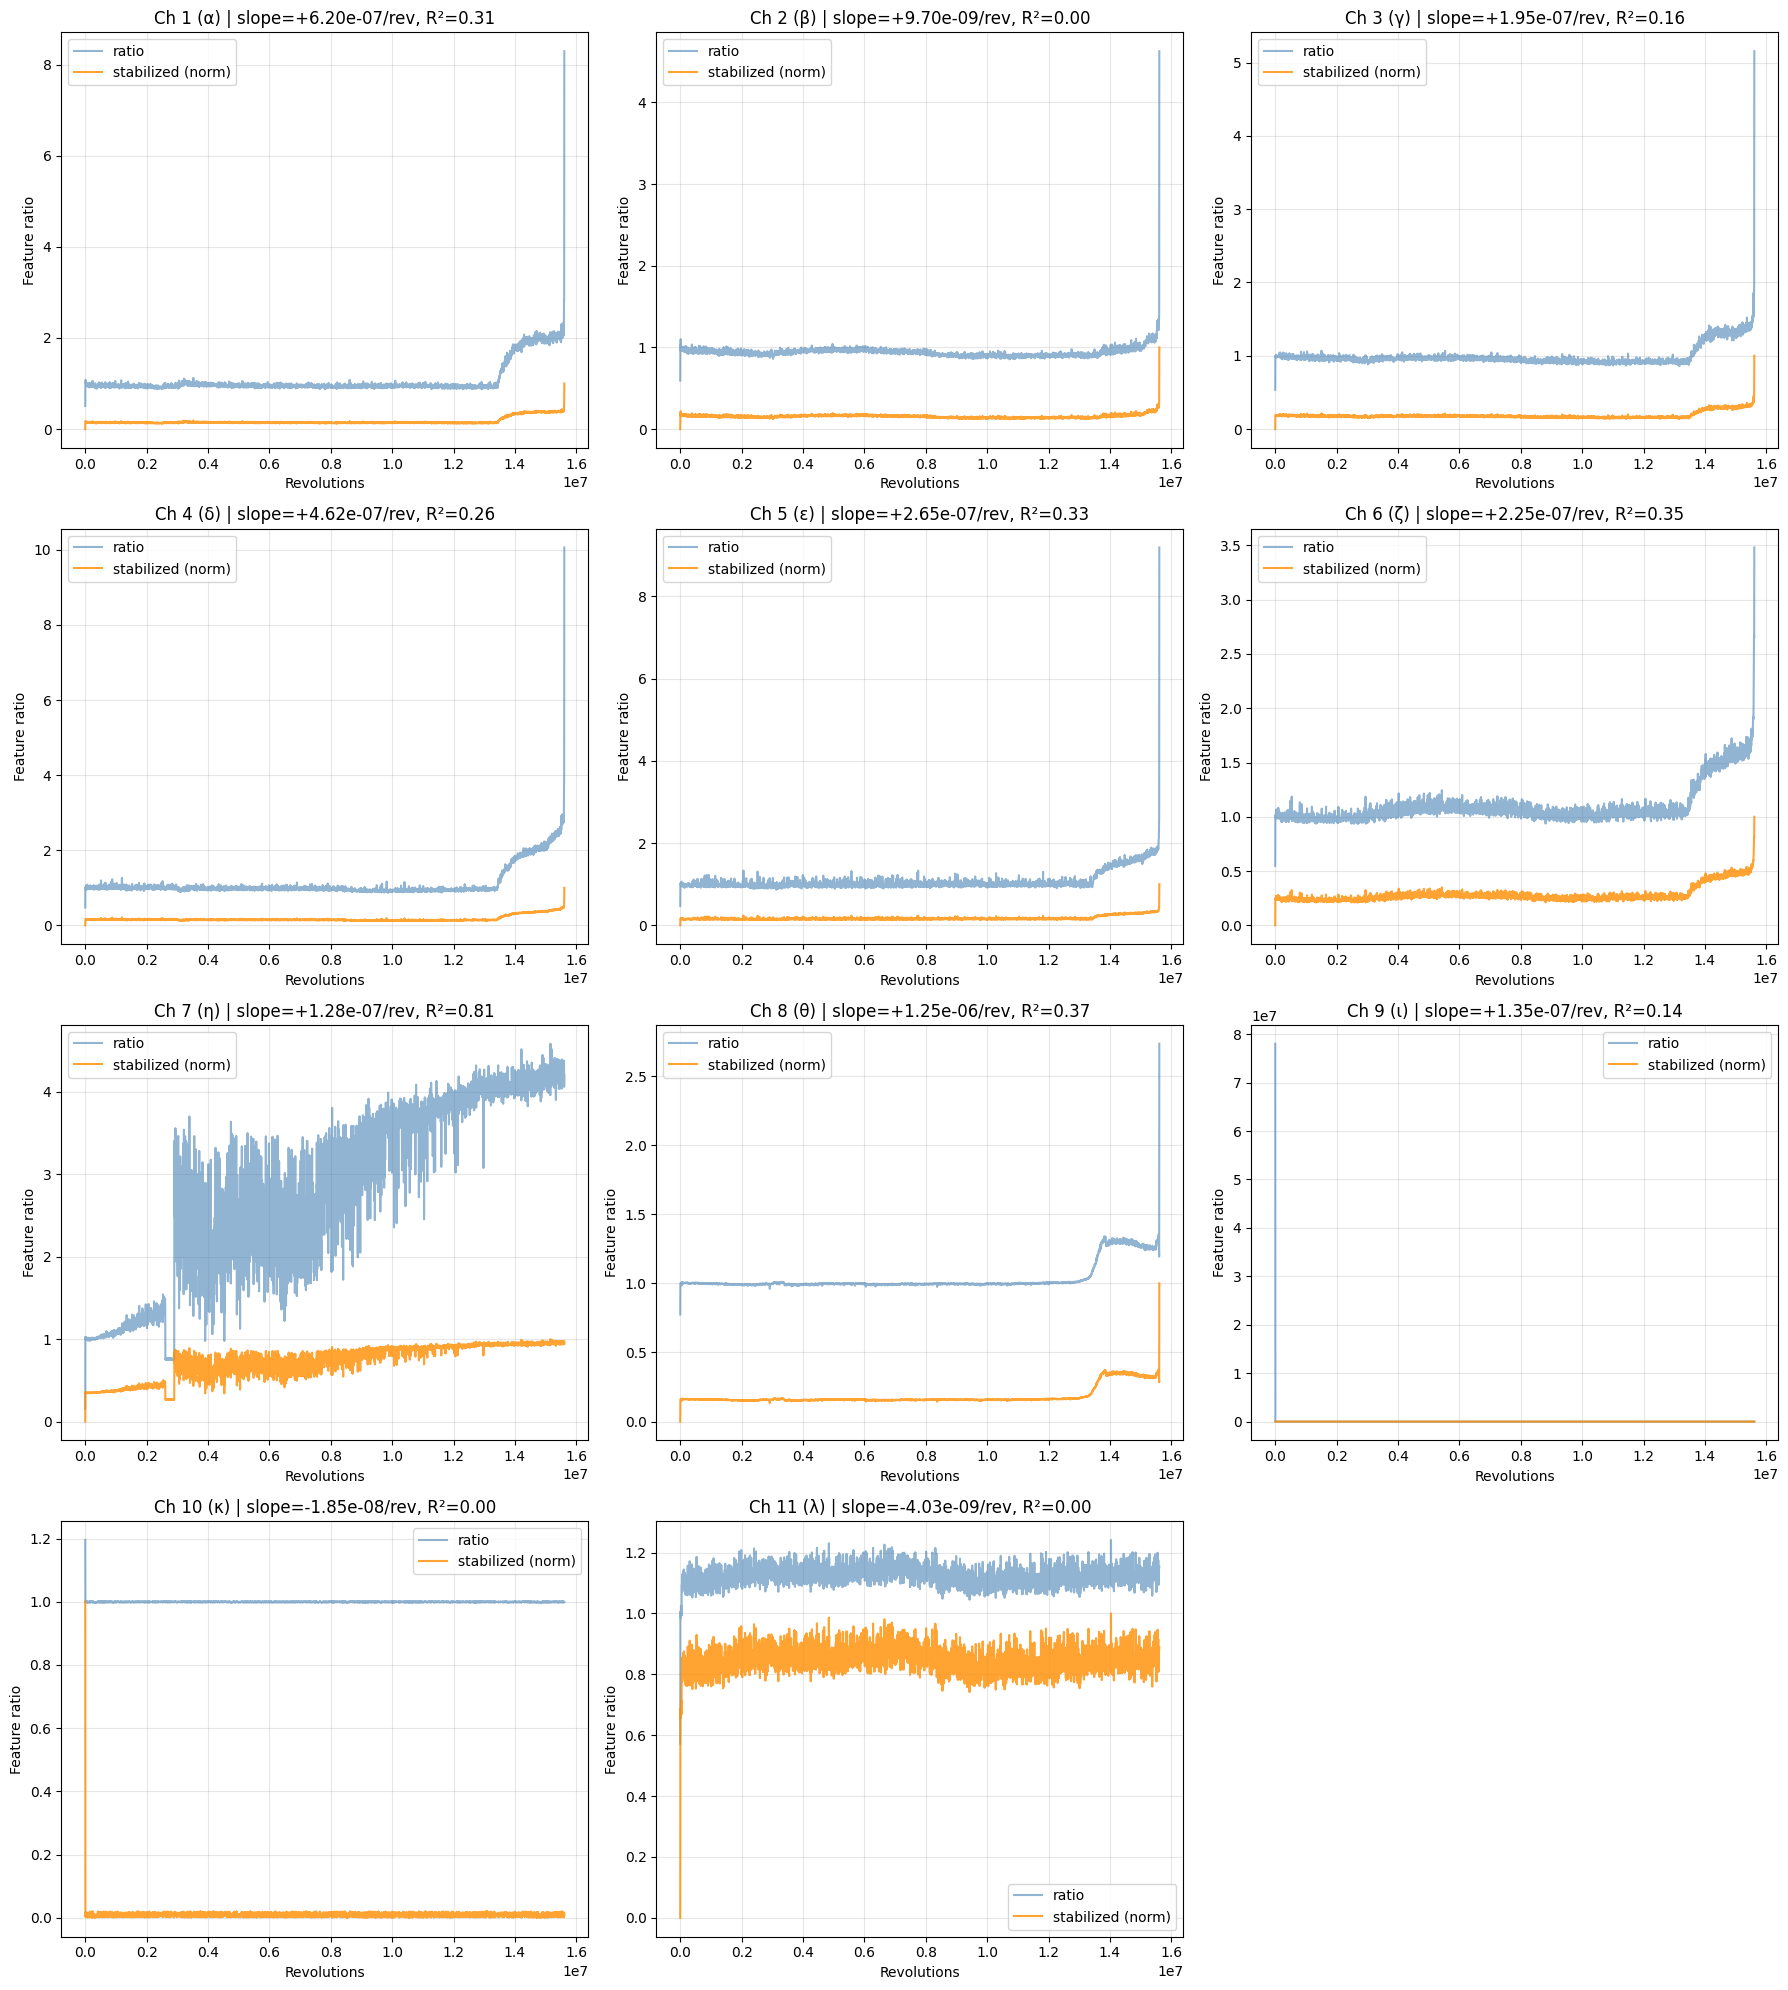

In [ ]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G4'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G5:Pinion breakage, and pitting, and output gear pitting: RPM 2400, Torque 26.5, Lifetime 5862

G5 cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+3.232318e-07 per rev, R^2=0.231
Channel 2 (β): slope=+3.624392e-07 per rev, R^2=0.248
Channel 3 (γ): slope=+4.232027e-07 per rev, R^2=0.302
Channel 4 (δ): slope=+4.948240e-07 per rev, R^2=0.365
Channel 5 (ε): slope=+2.108435e-07 per rev, R^2=0.417
Channel 6 (ζ): slope=+3.741980e-07 per rev, R^2=0.374
Channel 7 (η): slope=-3.359867e-08 per rev, R^2=0.004
Channel 8 (θ): slope=+3.325810e-07 per rev, R^2=0.252
Channel 9 (ι): slope=-3.953011e-08 per rev, R^2=0.002
Channel 10 (κ): slope=-1.552792e-08 per rev, R^2=0.001
Channel 11 (λ): slope=+1.088530e-08 per rev, R^2=0.003


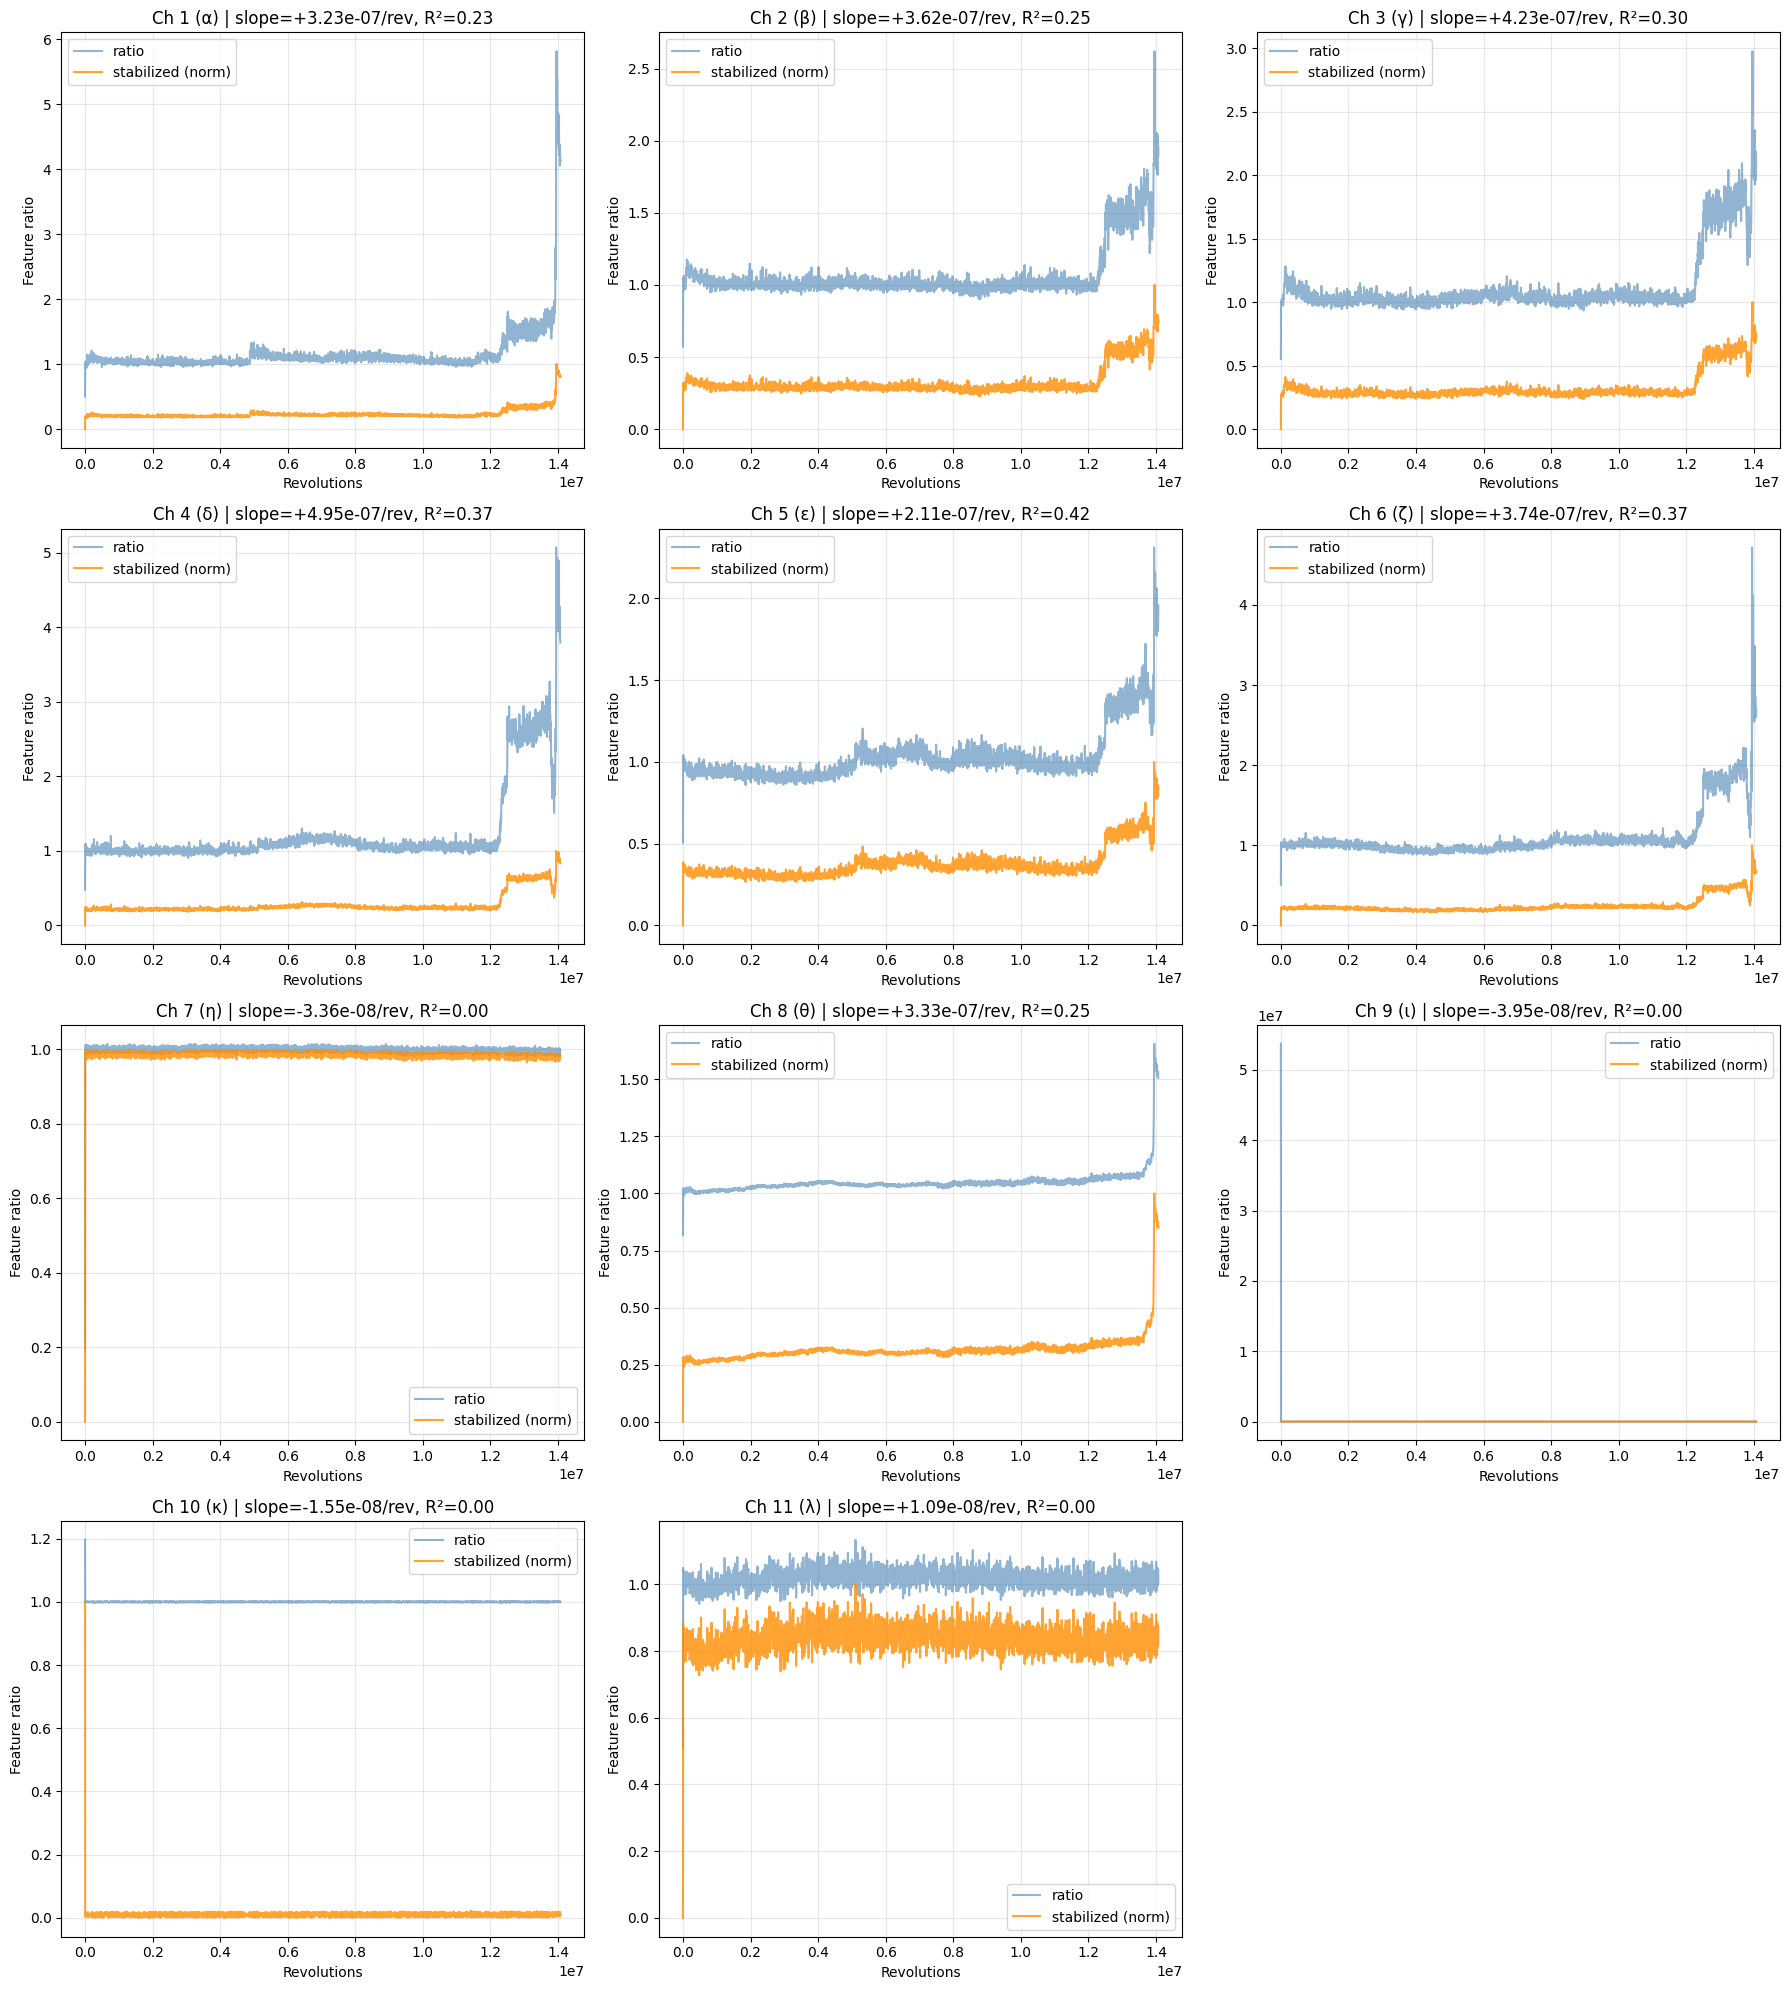

In [4]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G5'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

Cross Evaluation, determining likely indicators of failure within the data based on previouis parsing.

Failure profiles, graphical fingerprints, and expected lifetime impacts

Pinion tooth breakage + gear spalling (G1, 17.9 Nm, 2874 min)
• 	Core cluster: {1, 3, 4, 5, 6}; precursor/counter‑phase: {2}; echo: {8, 11}; non‑participants: {7, 9, 10}
• 	Graphical motifs:
• 	Early–mid epochs: Steady early; synchronized surges around 5 rev, stepwise upticks with widening chaos.
• 	Channel signatures: 1/3/6 replicate with sharp upticks; 2 spikes at 3.3/4 then dips; 5 tracks the cluster; 8 shows torque aberrations aligned to surges.
• 	Coefficient tendencies:
• 	Moderate slopes in γ/δ/ε with mid R², coherence rises near failure windows.
• 	2 shows counter‑phase behavior; 8 correlates when the cluster surges.
• 	Probable lifetime impact:
• 	Baseline for breakage+spalling at 17.9 Nm.
• 	Time reduction vs dispersed breakage (G2): ~5–10% shorter (more phase‑coherent surges).
• 	Time extension vs compressed spalling+plastic (G3): ~2–3× longer.

Pinion tooth breakage only (G2, 17.9 Nm, 3102 min)
• 	Core cluster: {1, 3, 4, 5, 6}; counter‑phase: {2}; chaotic resonance: {8}; non‑participants: {7, 9, 10}
• 	Graphical motifs:
• 	Greater dispersion: Early spikes (1 at 0.8–0.9), dense multi‑axis activity, but phase drift and intermittent relief epochs.
• 	2 spikes at 5 and 6.1 then drops pre‑failure; 8 exhibits chaotic waveform not cleanly predictive.
• 	Coefficient tendencies:
• 	Similar slopes to G1 but lower coherence stability; bursts are less synchronized.
• 	Probable lifetime impact:
• 	Longest of the 17.9 Nm breakage modes due to dispersion.
• 	Time extension vs G1: +5–10%.
• 	Time extension vs G3: ~3×.

Pinion spalling + plastic deformation (G3, 17.9 Nm, 1060 min)
• 	Core cluster: {1, 2, 4, 5, 6}; composite amplifier: {3}; torque resonance: {8}; non‑participants: {7, 9, 10}
• 	Graphical motifs:
• 	Compressed failure: Early destabilizers (1 at 0.65; 2 at 1.1; 4 at 0.5–1.3); rapid progression crest (5/6 from 1.45–2.3), synchronized terminal spike at 2.5.
• 	8 aligns late (2.3–2.5) after early variability.
• 	Coefficient tendencies:
• 	High mid‑phase crest density and rising coherence tightly near terminal window; 5/6 show steeper mid‑phase slopes.
• 	Probable lifetime impact:
• 	Shortest at 17.9 Nm.
• 	Time reduction vs G1/G2: ~65–70% shorter.
• 	Indicator: Early spike density + tight terminal synchrony.

Pinion pitting + breakage; output gear pitting (G4, 26.5 Nm, 6504 min)
• 	Core cluster: {1–6, 8}; resonant phasor: {7}; echo: {11}; non‑participants: {9, 10}
• 	Graphical motifs:
• 	Late parabolic ramp: Steady until ~1.3–1.4; smooth quadratic rise to terminal spike at 1.55–1.58.
• 	7 shows amplitude‑modulated resonance (early chaotic cresting, tapering toward failure).
• 	Coefficient tendencies:
• 	Moderate slopes in δ/ζ/γ; ε flattens (saturation); high R² in 7, θ surges late.
• 	Probable lifetime impact:
• 	Longest at 26.5 Nm given pitting‑dominated slow burn.
• 	Time extension vs G5: ~10–20% longer.
• 	Indicator: Strong η envelope variance + late torque coherence.

Pinion breakage + pitting; output gear pitting (G5, 26.5 Nm, 5862 min)
• 	Core cluster: {1–6}; late torque marker: {8}; echo: {11}; non‑participants: {7, 9, 10}
• 	Graphical motifs:
• 	Segmented ramp: Early alignment at 1.25, slight plateau → deep trough → terminal snap at 1.4; tight co‑spike synchrony.
• 	8 spikes at ~1.35 (lags cluster); 7 steady (no resonance buildup).
• 	Coefficient tendencies:
• 	Sharper piecewise slopes near terminal; ε visually ramps but slope metrics show saturation.
• 	Probable lifetime impact:
• 	Shorter than G4 at 26.5 Nm.
• 	Time reduction vs G4: ~10–20% shorter.
• 	Indicator: Early cluster alignment + trough depth + small torque lag.

G6: Test Data set; RPM 2400, Torque 26.5, cause and liftime to be determined.

G6 Test 1

G6 (Test 1) cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+7.488494e-04 per rev, R^2=0.470
Channel 2 (β): slope=+8.386415e-04 per rev, R^2=0.494
Channel 3 (γ): slope=+2.684962e-04 per rev, R^2=0.474
Channel 4 (δ): slope=+2.995319e-04 per rev, R^2=0.336
Channel 5 (ε): slope=+5.518895e-04 per rev, R^2=0.395
Channel 6 (ζ): slope=+3.555788e-04 per rev, R^2=0.372
Channel 7 (η): slope=+1.743047e-03 per rev, R^2=0.422
Channel 8 (θ): slope=+1.402600e-03 per rev, R^2=0.426
Channel 9 (ι): slope=-2.878666e-02 per rev, R^2=0.428
Channel 10 (κ): slope=-3.764086e-03 per rev, R^2=0.420
Channel 11 (λ): slope=+9.008094e-04 per rev, R^2=0.418


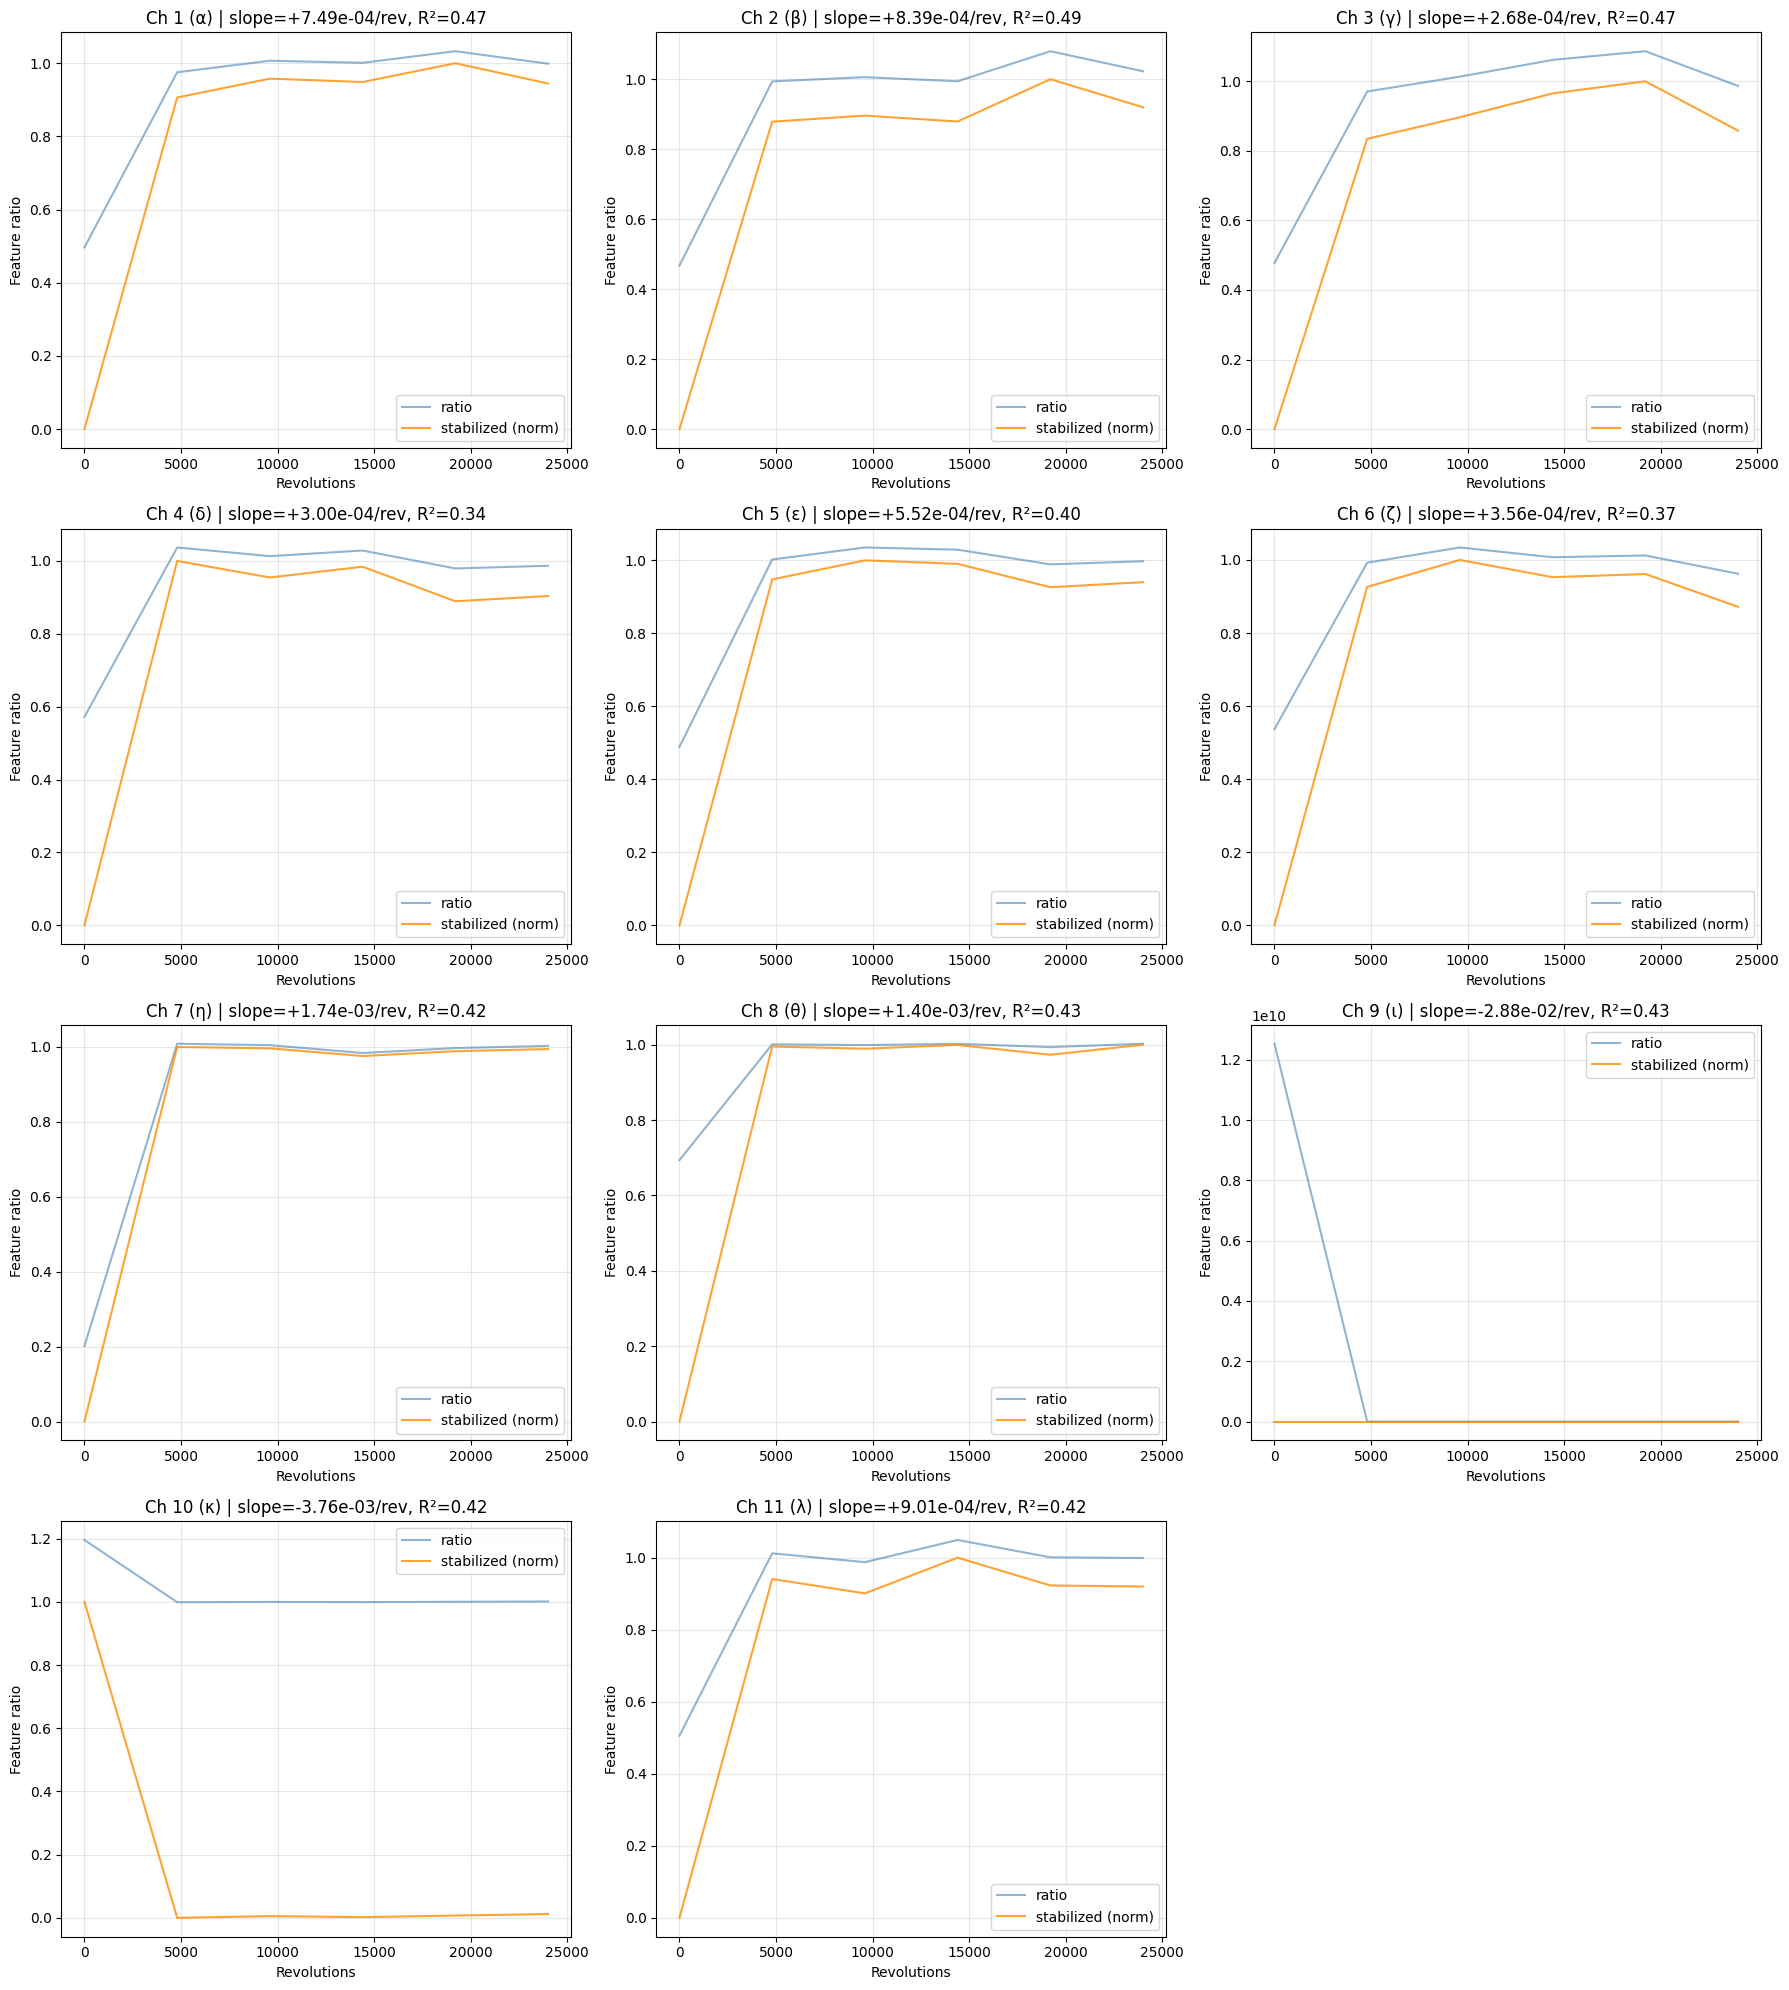

In [5]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G6 (Test 1)'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G6 Test 2

G6 (Test 2) cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+5.361295e-04 per rev, R^2=0.402
Channel 2 (β): slope=+3.601693e-04 per rev, R^2=0.365
Channel 3 (γ): slope=+2.657466e-04 per rev, R^2=0.379
Channel 4 (δ): slope=+3.715269e-04 per rev, R^2=0.392
Channel 5 (ε): slope=+4.547404e-04 per rev, R^2=0.368
Channel 6 (ζ): slope=+2.892519e-04 per rev, R^2=0.461
Channel 7 (η): slope=+2.027915e-03 per rev, R^2=0.446
Channel 8 (θ): slope=+3.824547e-03 per rev, R^2=0.431
Channel 9 (ι): slope=-1.720842e-02 per rev, R^2=0.427
Channel 10 (κ): slope=-2.812588e-03 per rev, R^2=0.422
Channel 11 (λ): slope=+6.749788e-04 per rev, R^2=0.523


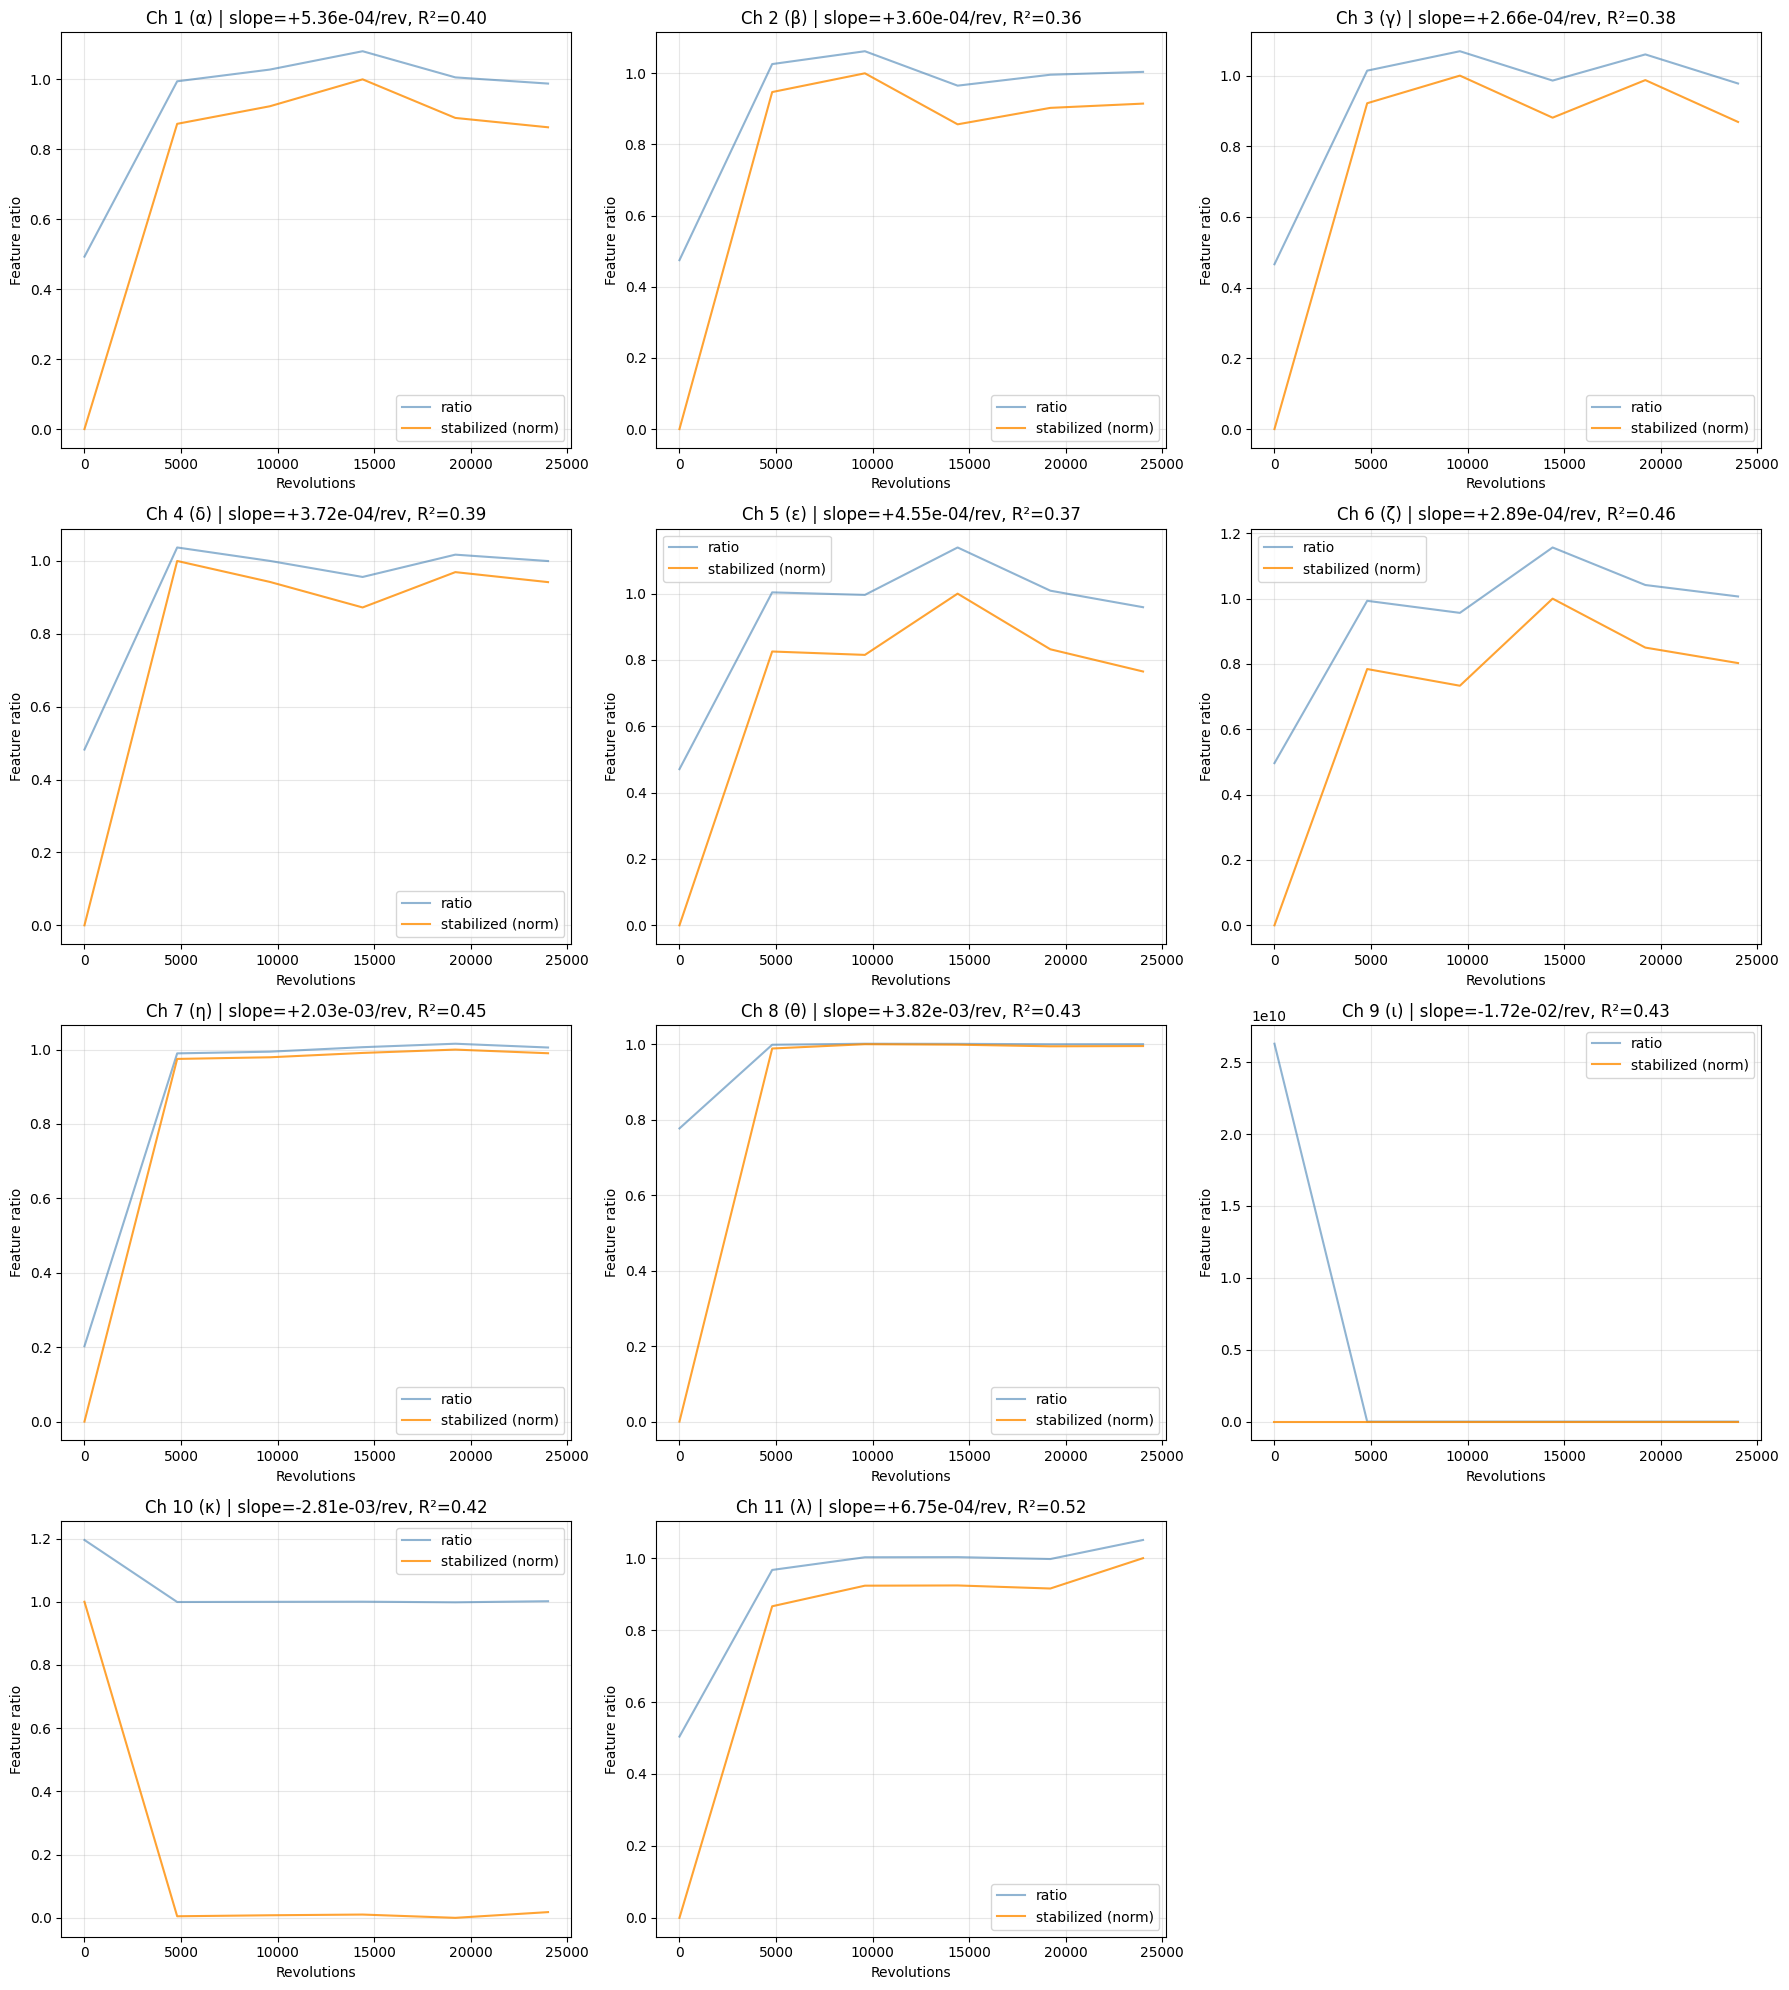

In [6]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G6 (Test 2)'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G6 Test 3

G6 (Test 3) cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+5.230647e-04 per rev, R^2=0.485
Channel 2 (β): slope=+3.465531e-04 per rev, R^2=0.434
Channel 3 (γ): slope=+2.938181e-04 per rev, R^2=0.418
Channel 4 (δ): slope=+4.478132e-04 per rev, R^2=0.366
Channel 5 (ε): slope=+4.273080e-04 per rev, R^2=0.408
Channel 6 (ζ): slope=+2.608704e-04 per rev, R^2=0.374
Channel 7 (η): slope=+1.908398e-03 per rev, R^2=0.422
Channel 8 (θ): slope=+5.350696e-03 per rev, R^2=0.439
Channel 9 (ι): slope=-1.430166e-02 per rev, R^2=0.432
Channel 10 (κ): slope=-2.460213e-03 per rev, R^2=0.432
Channel 11 (λ): slope=+1.863677e-04 per rev, R^2=0.281


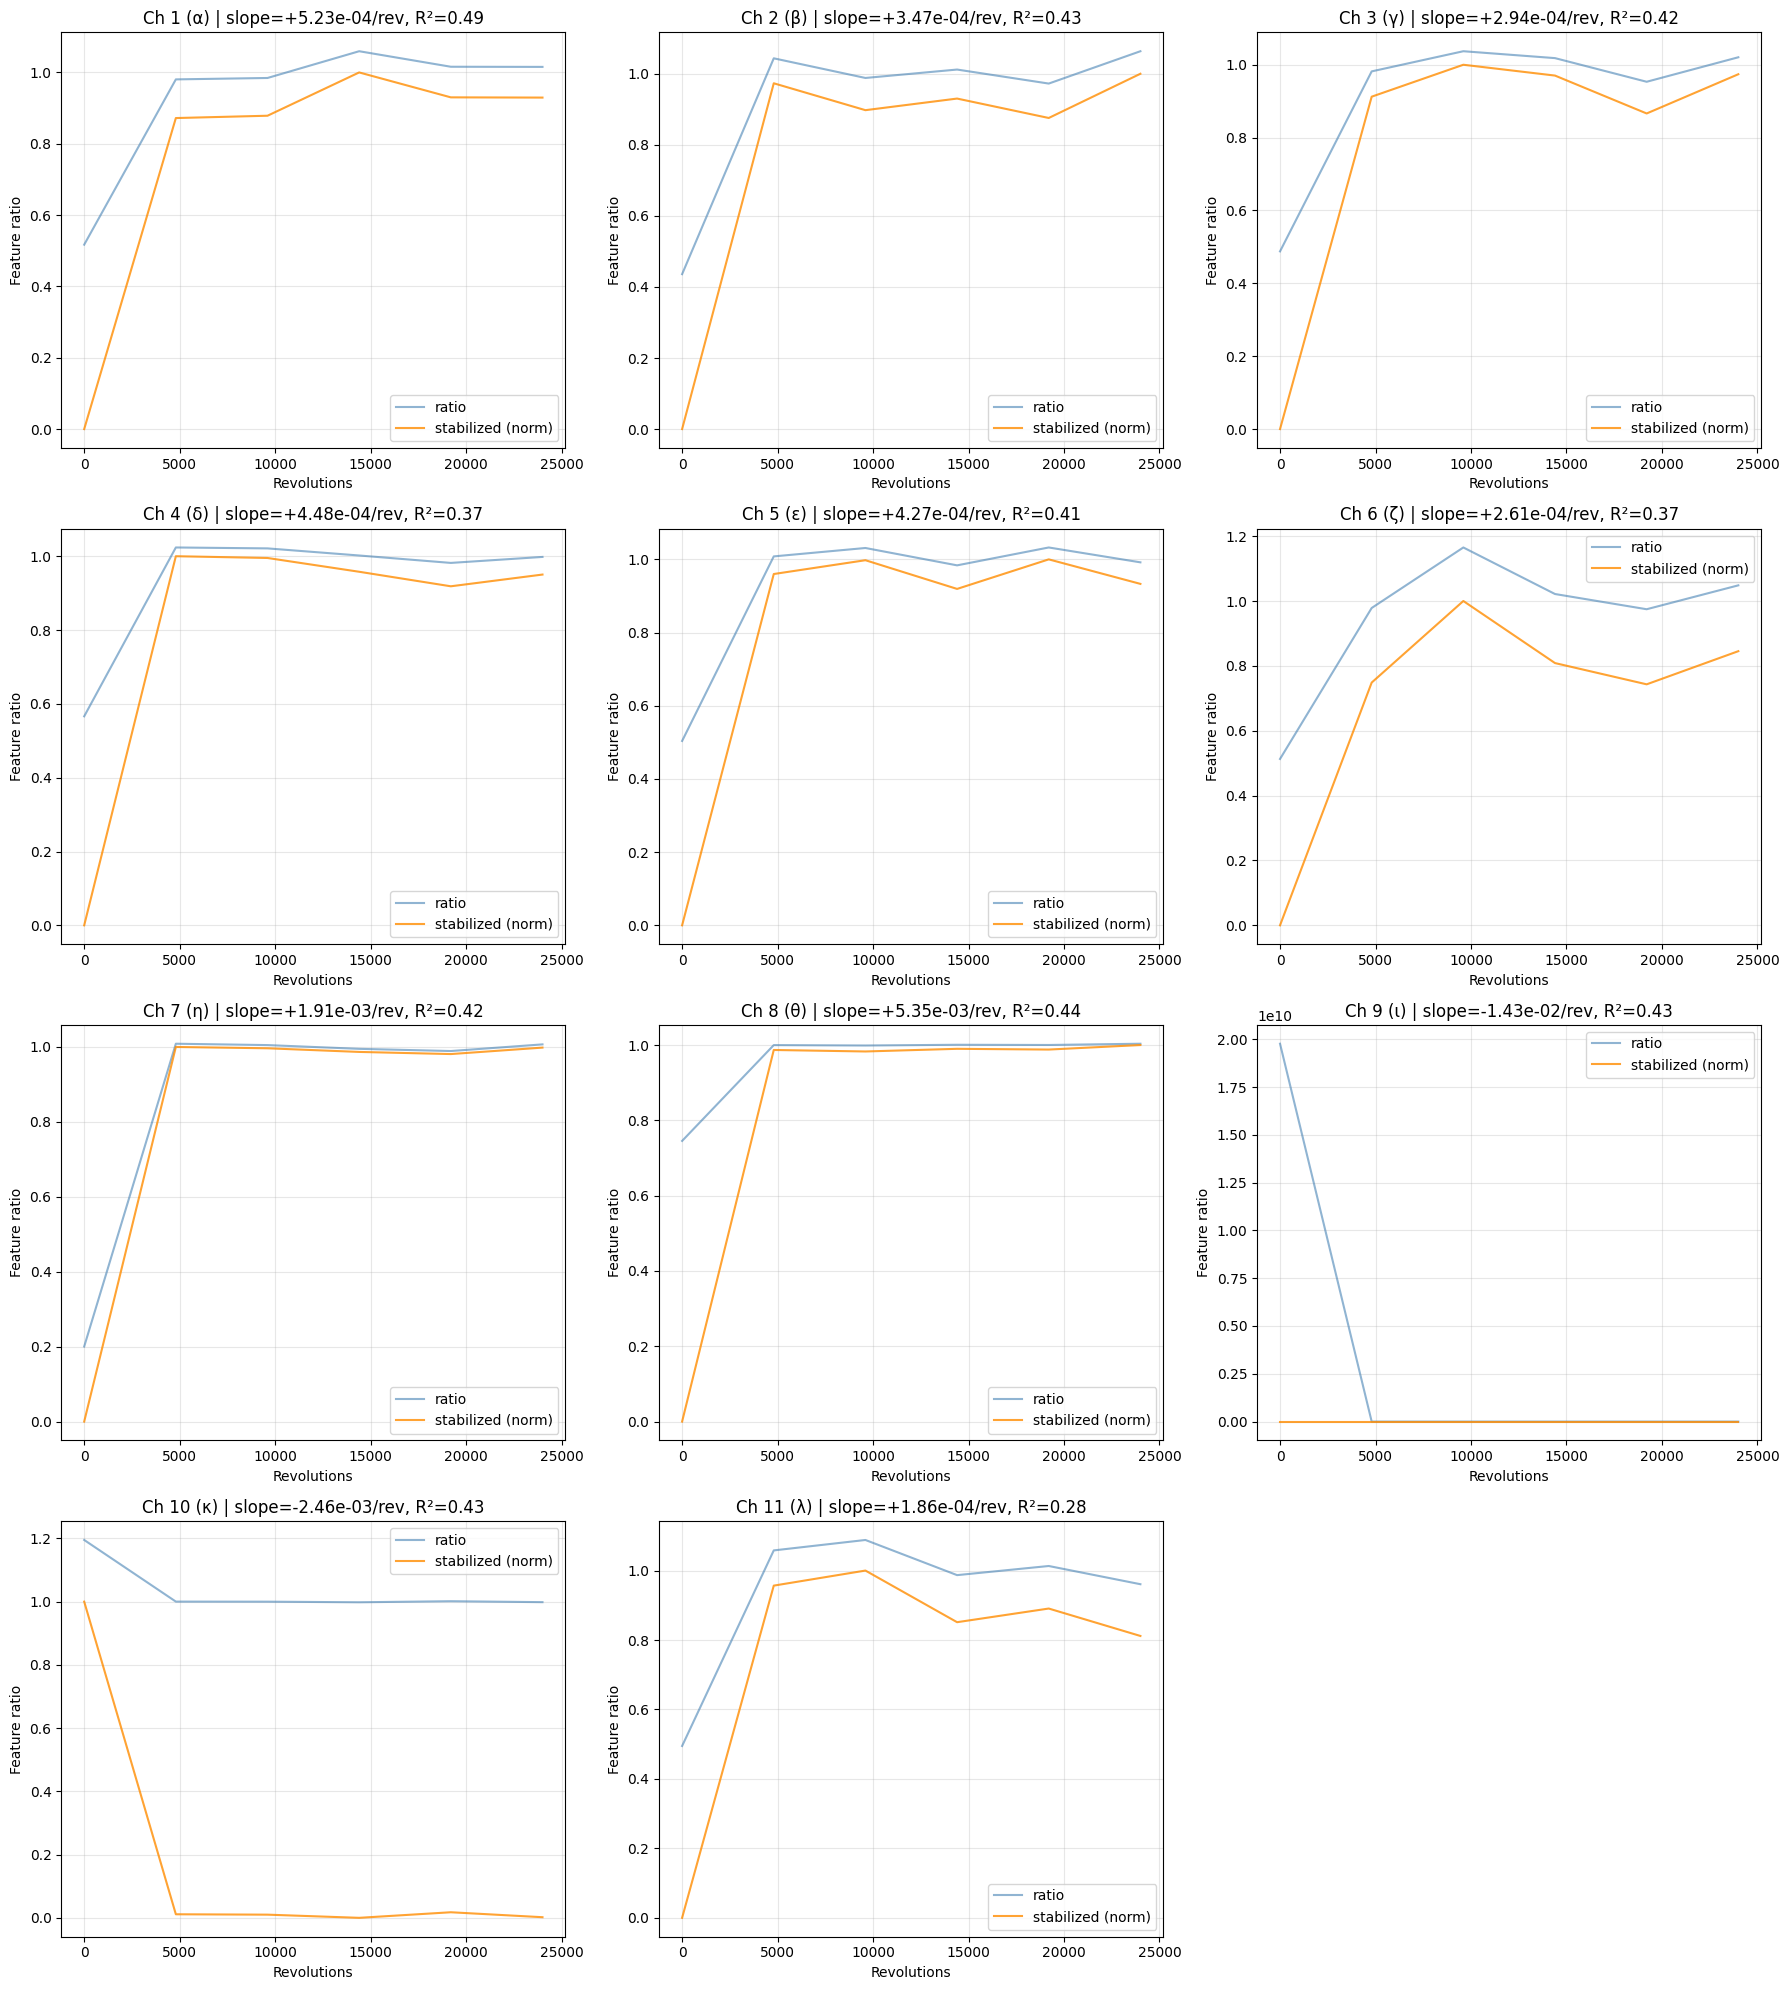

In [7]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G6 (Test 3)'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G6 Test 4

G6 (Test 4) cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+4.772380e-04 per rev, R^2=0.472
Channel 2 (β): slope=+5.696084e-04 per rev, R^2=0.425
Channel 3 (γ): slope=+6.463580e-04 per rev, R^2=0.515
Channel 4 (δ): slope=+4.019828e-04 per rev, R^2=0.419
Channel 5 (ε): slope=+7.003092e-04 per rev, R^2=0.420
Channel 6 (ζ): slope=+9.676965e-04 per rev, R^2=0.438
Channel 7 (η): slope=+2.736276e-03 per rev, R^2=0.425
Channel 8 (θ): slope=+4.370742e-03 per rev, R^2=0.423
Channel 9 (ι): slope=-3.829468e-02 per rev, R^2=0.428
Channel 10 (κ): slope=-3.089416e-03 per rev, R^2=0.425
Channel 11 (λ): slope=+7.731093e-04 per rev, R^2=0.449


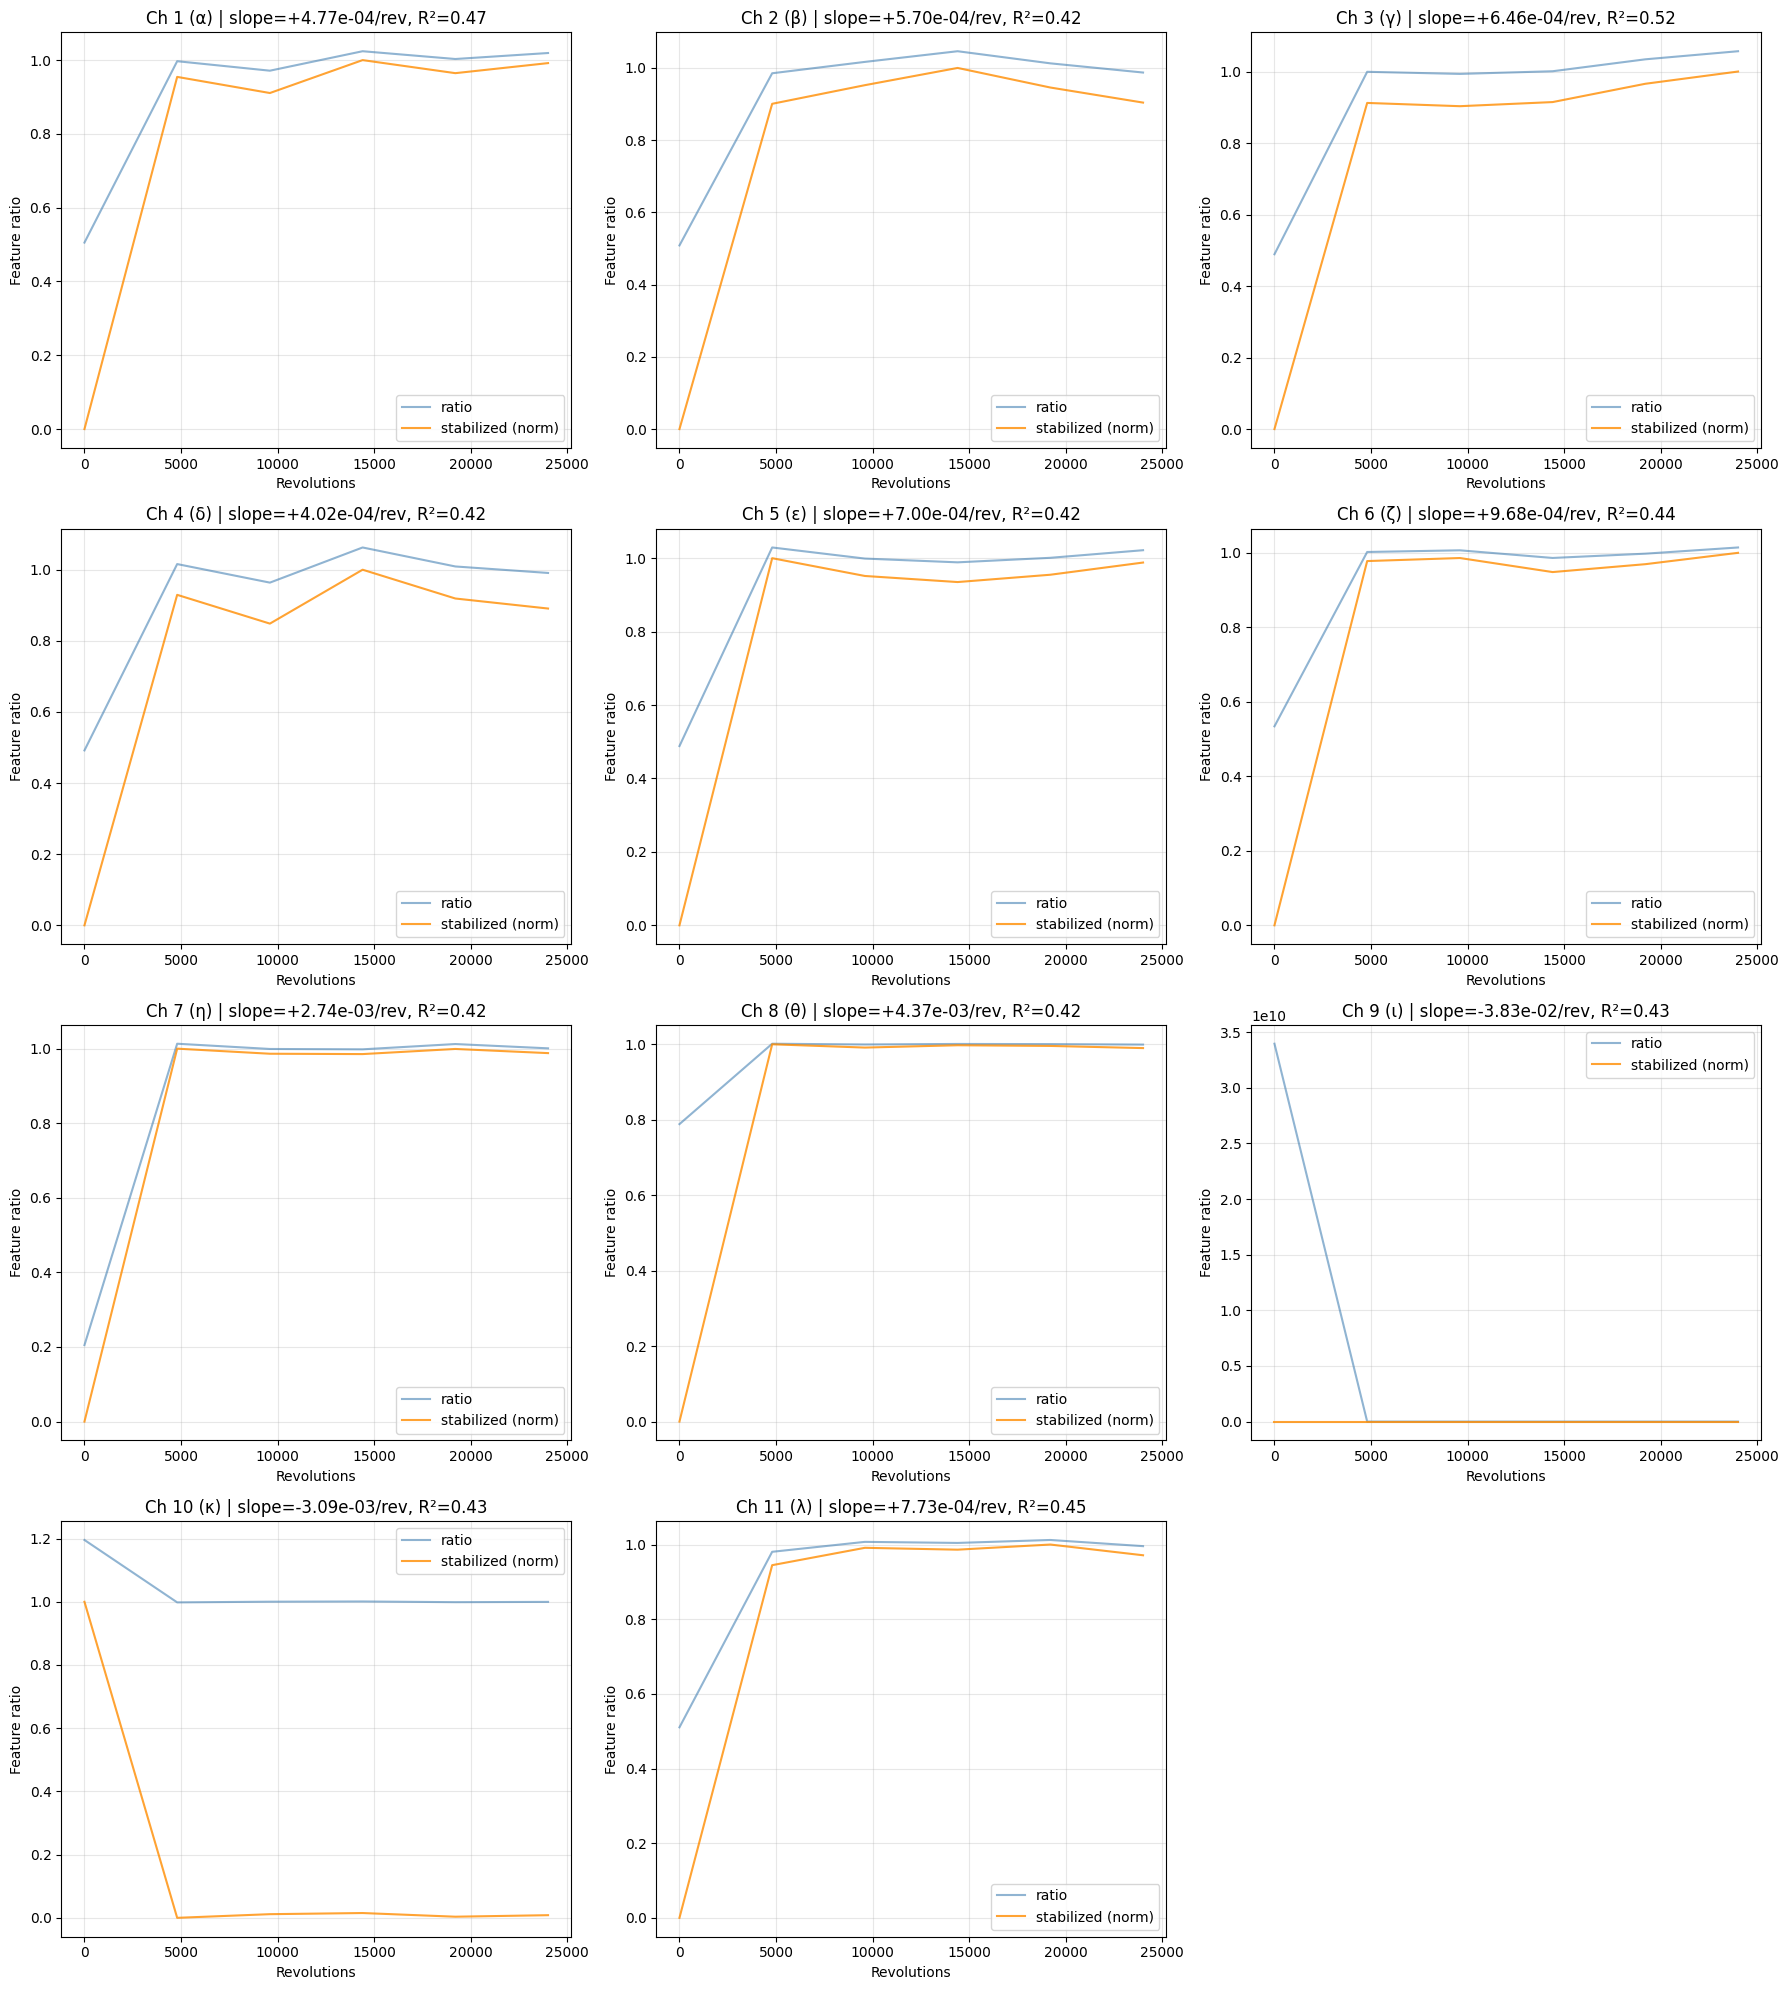

In [8]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G6 (Test 4)'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

G6 Test 5

G6 (Test 5) cycle-based coefficients (slope per revolution) with R^2:
Channel 1 (α): slope=+2.727270e-04 per rev, R^2=0.308
Channel 2 (β): slope=+3.858567e-04 per rev, R^2=0.411
Channel 3 (γ): slope=+4.807990e-04 per rev, R^2=0.475
Channel 4 (δ): slope=+4.087208e-04 per rev, R^2=0.403
Channel 5 (ε): slope=+5.057283e-04 per rev, R^2=0.505
Channel 6 (ζ): slope=+7.268636e-04 per rev, R^2=0.341
Channel 7 (η): slope=+2.183169e-03 per rev, R^2=0.427
Channel 8 (θ): slope=+1.113728e-03 per rev, R^2=0.413
Channel 9 (ι): slope=-1.085824e-02 per rev, R^2=0.428
Channel 10 (κ): slope=-7.446374e-03 per rev, R^2=0.430
Channel 11 (λ): slope=+8.780536e-04 per rev, R^2=0.389


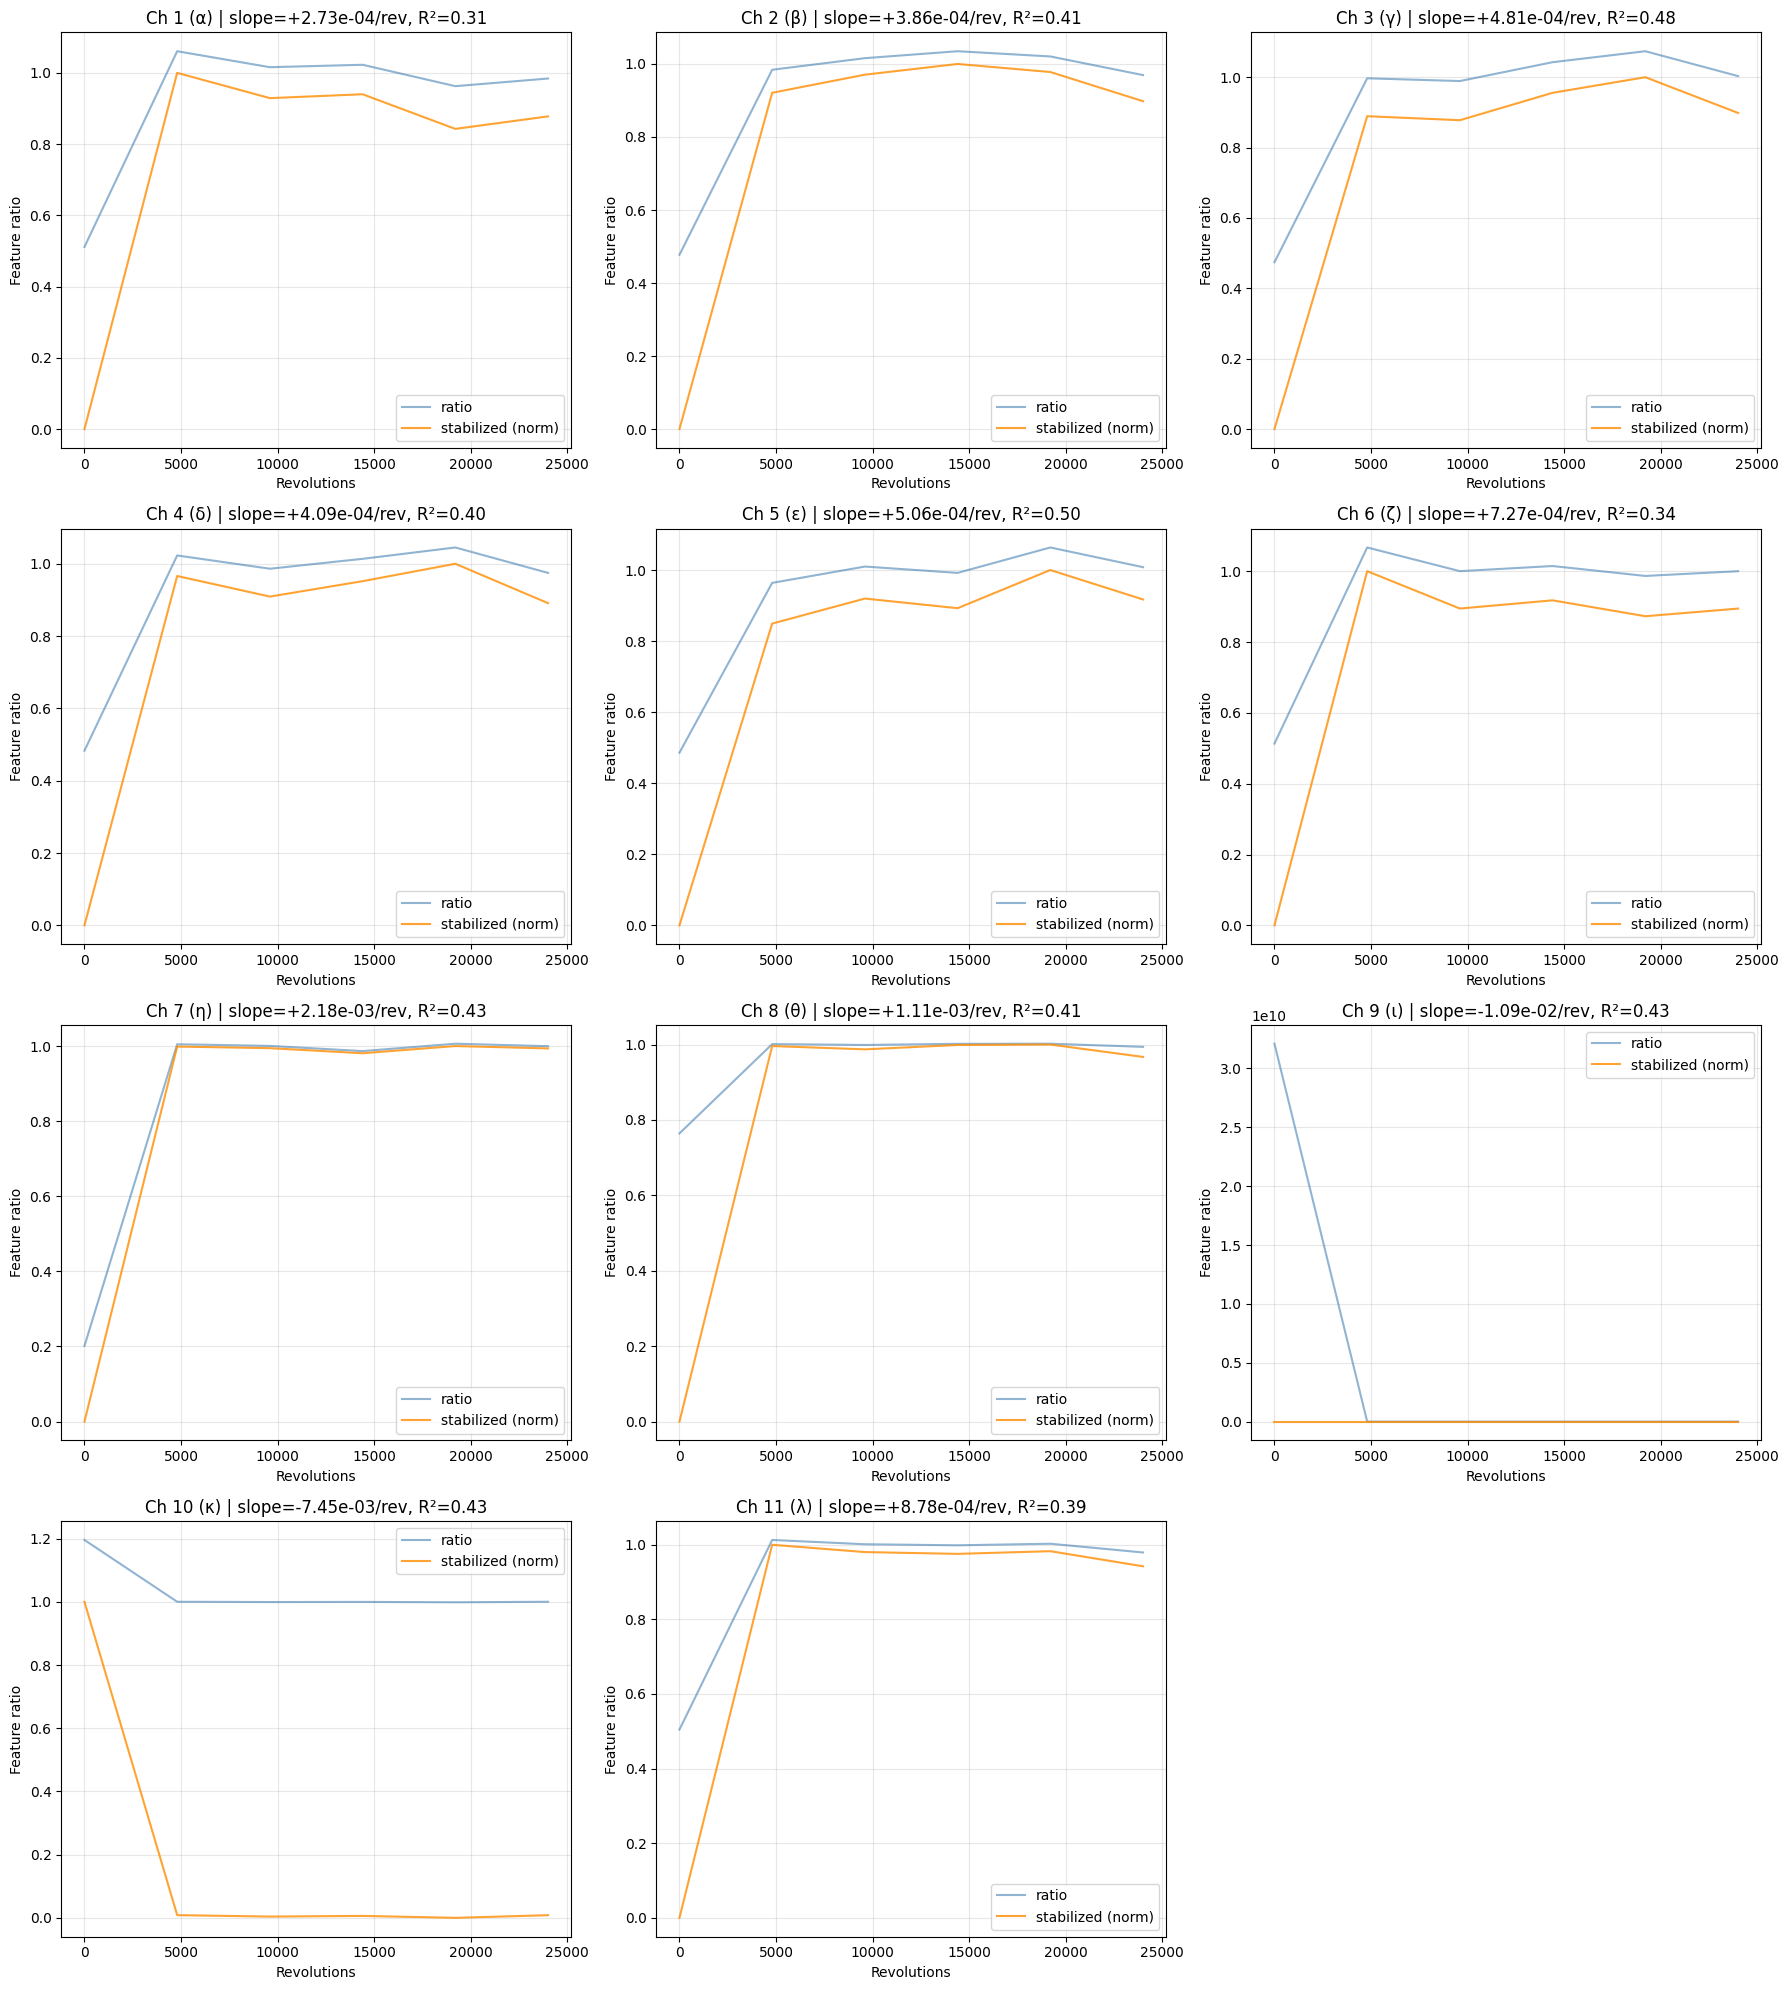

In [9]:
# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import hilbert
from scipy.stats import iqr
import csv

# %% Config
DATA_DIR = Path('/content/')
RUN = 'G6 (Test 5)'
BURST_LEN = 32768
BASELINE_K = 10
RPM = 2400
BURST_INTERVAL_MIN = 2.0
REV_PER_BURST = RPM * BURST_INTERVAL_MIN  # 4800 revs per burst

channel_symbols = {
    1: 'α', 2: 'β', 3: 'γ', 4: 'δ', 5: 'ε', 6: 'ζ',
    7: 'η', 8: 'θ', 9: 'ι', 10: 'κ', 11: 'λ'
}

file_map = {
    1: 'channel_1.csv', 2: 'channel_2.csv', 3: 'channel_3.csv',
    4: 'channel_4.csv', 5: 'channel_5.csv', 6: 'channel_6.csv',
    7: 'channel_7.csv', 8: 'channel_8.csv', 9: 'channel_9.csv',
    10: 'channel_10.csv', 11: 'channel_11.csv'
}

# %% Burst iterator using raw CSV reader
def burst_iterator(channel_csv):
    samples = []
    with open(channel_csv, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for val in row:
                try:
                    samples.append(float(val))
                except:
                    continue
    samples = np.array(samples, dtype=np.float32)
    total_samples = samples.size
    num_bursts = total_samples // BURST_LEN
    for i in range(num_bursts):
        yield samples[i * BURST_LEN : (i + 1) * BURST_LEN]

# %% Safe stats
def safe_mean(x): return np.mean(x) if x.size > 0 else 0.0
def safe_std(x): return np.std(x) if x.size > 1 else 0.0
def safe_iqr(x): return iqr(x) if x.size >= 4 else (np.max(x) - np.min(x) if x.size > 1 else 1.0)

# %% Feature extraction
def extract_features(sig, ch_id):
    if sig.size == 0:
        return {'crest': 0.0, 'kurt': 0.0, 'env_band': 0.0}
    rms = np.sqrt(np.mean(sig**2))
    crest = np.max(np.abs(sig)) / (rms + 1e-9)
    mu = safe_mean(sig)
    sd = safe_std(sig) + 1e-9
    z = (sig - mu) / sd
    kurt = np.mean(z**4)
    if ch_id == 9:
        analytic = hilbert(sig)
        envelope = np.abs(analytic)
        env_band = np.sum(envelope**2) / len(envelope)
    else:
        env_band = 0.0
    return {'crest': crest, 'kurt': kurt, 'env_band': env_band}

def select_primary_feature(ch_id, feats):
    if ch_id == 9:
        return feats['env_band']
    elif ch_id in {1,2,3,4,5,6,11}:
        return feats['crest'] + feats['kurt']
    else:
        return feats['kurt']

def nth_stabilize(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0: return np.zeros_like(x)
    x = np.log1p(np.maximum(x, 0.0))
    med = np.median(x)
    scale = safe_iqr(x) + 1e-6
    return (x - med) / scale

def fit_time_coefficient(x_axis, y):
    if len(x_axis) < 2 or len(y) < 2:
        return 0.0, 0.0, 0.0
    X = np.vstack([x_axis, np.ones_like(x_axis)]).T
    beta, intercept = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = beta * x_axis + intercept
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    r2 = 1.0 - ss_res / ss_tot
    return float(beta), float(intercept), float(r2)

# %% Process G1
run_dir = DATA_DIR / RUN
channel_trajectories = {}

for ch_id, fname in file_map.items():
    path = run_dir / fname
    if not path.exists():
        print(f"Missing file for channel {ch_id}: {fname}")
        continue
    primary = []
    for burst in burst_iterator(path):
        feats = extract_features(burst, ch_id)
        primary.append(select_primary_feature(ch_id, feats))
    primary = np.array(primary, dtype=np.float64)
    T = primary.shape[0]
    if T == 0:
        print(f"No bursts for channel {ch_id}")
        continue
    revs = np.arange(T, dtype=np.float64) * REV_PER_BURST
    base = np.median(primary[:min(BASELINE_K, T)]) if T > 0 else 1.0
    ratio = primary / (base + 1e-9)
    ratio_stab = nth_stabilize(ratio)
    slope, intercept, r2 = fit_time_coefficient(revs, ratio_stab)
    channel_trajectories[ch_id] = {
        'symbol': channel_symbols[ch_id],
        'revs': revs,
        'feature_ratio': ratio,
        'feature_ratio_stab': ratio_stab,
        'slope_per_rev': slope,
        'r2': r2
    }

# %% Print coefficients
print(f'{RUN} cycle-based coefficients (slope per revolution) with R^2:')
rows = []
for ch_id in sorted(channel_trajectories.keys()):
    sym = channel_trajectories[ch_id]['symbol']
    slope = channel_trajectories[ch_id]['slope_per_rev']
    r2 = channel_trajectories[ch_id]['r2']
    rows.append((ch_id, sym, slope, r2))
    print(f'Channel {ch_id} ({sym}): slope={slope:+.6e} per rev, R^2={r2:.3f}')

df_coef = pd.DataFrame(rows, columns=['channel','symbol','slope_per_rev','r2'])
df_coef.to_csv(run_dir / f'{RUN}_cycle_coefficients.csv', index=False)

# %% Plot
ncols = 3
nrows = int(np.ceil(len(channel_trajectories)/ncols))
plt.figure(figsize=(18, 5*nrows))
idx = 1
for ch_id in sorted(channel_trajectories.keys()):
    data = channel_trajectories[ch_id]
    revs = data['revs']
    ratio = data['feature_ratio']
    stab = data['feature_ratio_stab']
    if stab.size < 2:
        continue
    stab_norm = (stab - np.min(stab)) / (np.max(stab) - np.min(stab) + 1e-9)
    plt.subplot(nrows, ncols, idx)
    plt.plot(revs, ratio, color='steelblue', alpha=0.6, label='ratio')
    plt.plot(revs, stab_norm, color='darkorange', alpha=0.8, label='stabilized (norm)')
    plt.title(f'Ch {ch_id} ({data["symbol"]}) | slope={data["slope_per_rev"]:+.2e}/rev, R²={data["r2"]:.2f}')
    plt.xlabel('Revolutions')
    plt.ylabel('Feature ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    idx += 1
plt.tight_layout()
plt.show()

Prediction 1: non-normalized

In [14]:
import os
import pandas as pd
import numpy as np

# Known lifetimes for training runs (minutes)
train_lifetimes = {
    "G1": 2874,
    "G2": 3102,
    "G3": 1060,
    "G4": 6504,
    "G5": 5862,
}

# --- Step 1: Load training sets ---
train_data = {}
for i in range(1, 6):
    path = f"/content/G{i}/G{i}_cycle_coefficients.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        train_data[f"G{i}"] = df
    else:
        print(f"Warning: {path} not found")

# --- Step 2: Load G6 test sets ---
test_data = {}
for i in range(1, 6):
    path = f"/content/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        test_data[f"Test{i}"] = df
    else:
        print(f"Warning: {path} not found")

# --- Step 3: Function to compute distance between test and training ---
def compute_distance(test_df, train_df):
    # Merge on channel to align rows
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    # Use slope_per_rev as the main feature
    diff = merged["slope_per_rev_test"] - merged["slope_per_rev_train"]
    return np.linalg.norm(diff)

# --- Step 4: Predict lifetimes for G6 tests ---
results = {}
for test_id, test_df in test_data.items():
    best_match, best_dist = None, float("inf")
    for train_id, train_df in train_data.items():
        dist = compute_distance(test_df, train_df)
        if dist < best_dist:
            best_match, best_dist = train_id, dist
    pred = train_lifetimes[best_match]
    lower = int(pred * 0.9)
    upper = int(pred * 1.1)
    results[test_id] = (pred, lower, upper, best_match)

# --- Step 5: Build submission DataFrame ---
submission = pd.DataFrame([
    {"id": test_id.lower(),
     "prediction": vals[0],
     "lower_bound": vals[1],
     "upper_bound": vals[2]}
    for test_id, vals in results.items()
])

# --- Step 6: Save to CSV ---
submission.to_csv("submission.csv", index=False)

print("submission.csv created:")
print(submission)

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  test1        3102         2791         3412
1  test2        3102         2791         3412
2  test3        3102         2791         3412
3  test4        3102         2791         3412
4  test5        3102         2791         3412


Prediction 2: with normalization

In [15]:
import os
import pandas as pd
import numpy as np

# Known lifetimes for training runs (minutes)
train_lifetimes = {
    "G1": 2874,
    "G2": 3102,
    "G3": 1060,
    "G4": 6504,
    "G5": 5862,
}

# --- Step 1: Load training sets ---
train_data = {}
for i in range(1, 6):
    path = f"/content/G{i}/G{i}_cycle_coefficients.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        train_data[f"G{i}"] = df
    else:
        print(f"Warning: {path} not found")

# --- Step 2: Load G6 test sets ---
test_data = {}
for i in range(1, 6):
    path = f"/content/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        test_data[f"Test{i}"] = df
    else:
        print(f"Warning: {path} not found")

# --- Step 3: Define channel weights ---
# Heavier weight for η (7) and θ (8) since they are critical late-stage indicators
channel_weights = {7: 3.0, 8: 3.0}

# --- Step 4: Distance function with normalization, R², and weighting ---
def compute_distance(test_df, train_df):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))

    diffs = []
    for _, row in merged.iterrows():
        ch = row["channel"]
        w = channel_weights.get(ch, 1.0)

        # Normalize slope magnitudes by dividing by max absolute value in each vector
        slope_t = row["slope_per_rev_test"]
        slope_r = row["slope_per_rev_train"]
        # Avoid divide-by-zero
        denom = max(abs(slope_t), abs(slope_r), 1e-12)
        slope_diff = (slope_t - slope_r) / denom

        # R² difference (already bounded 0–1, so no normalization needed)
        r2_diff = row["r2_test"] - row["r2_train"]

        diffs.append(w * (slope_diff**2 + r2_diff**2))

    return np.sqrt(sum(diffs))

# --- Step 5: Predict lifetimes for G6 tests ---
results = {}
for test_id, test_df in test_data.items():
    best_match, best_dist = None, float("inf")
    for train_id, train_df in train_data.items():
        dist = compute_distance(test_df, train_df)
        if dist < best_dist:
            best_match, best_dist = train_id, dist
    pred = train_lifetimes[best_match]
    lower = int(pred * 0.9)
    upper = int(pred * 1.1)
    results[test_id] = (pred, lower, upper, best_match)

# --- Step 6: Build submission DataFrame ---
submission = pd.DataFrame([
    {"id": test_id.lower(),
     "prediction": vals[0],
     "lower_bound": vals[1],
     "upper_bound": vals[2]}
    for test_id, vals in results.items()
])

# --- Step 7: Save to CSV ---
submission.to_csv("submission.csv", index=False)

print("submission.csv created:")
print(submission)

# Optional: show which training run each test matched
for test_id, vals in results.items():
    print(f"{test_id} matched {vals[3]} with predicted lifetime {vals[0]}")

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  test1        1060          954         1166
1  test2        1060          954         1166
2  test3        1060          954         1166
3  test4        1060          954         1166
4  test5        1060          954         1166
Test1 matched G3 with predicted lifetime 1060
Test2 matched G3 with predicted lifetime 1060
Test3 matched G3 with predicted lifetime 1060
Test4 matched G3 with predicted lifetime 1060
Test5 matched G3 with predicted lifetime 1060


Nth Mathematics Based Cognition Engine Prediction; G4 G5 comparison only

In [16]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine (minimal integration)
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    # Core nth math estimator; here used to shape weights nonlinearly
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, n, epsilon=0.0, label=""):
        self.n = n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(n, epsilon)
        self.entropy = abs(epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        # Map estimate and clarity into a final weight
        # Higher clarity increases effective contribution; epsilon jitters small adjustments
        return float(self.estimate * self.clarity)

# Build a cognition map for channels (domain knowledge)
# Emphasize η (7) and θ (8) as late-stage indicators in 26.5 Nm regime
def build_channel_cognition_weights():
    # Base "n" encodes importance; epsilon introduces slight differentiation
    neurons = {
        1: QNeuron(1.5, 0.00, "α"),   # cluster member
        2: QNeuron(1.5, 0.00, "β"),   # cluster member
        3: QNeuron(1.6, 0.00, "γ"),
        4: QNeuron(1.6, 0.00, "δ"),
        5: QNeuron(1.8, 0.00, "ε"),   # progression
        6: QNeuron(1.8, 0.00, "ζ"),   # progression
        7: QNeuron(2.3, 0.02, "η"),   # resonant late-stage indicator (weighted higher)
        8: QNeuron(2.3, -0.02, "θ"),  # torque alignment indicator (weighted higher)
        9: QNeuron(1.2, 0.00, "ι"),   # often moot
        10: QNeuron(1.2, 0.00, "κ"),  # often moot
        11: QNeuron(1.4, 0.01, "λ"),  # resonance echo
    }
    return {ch: neurons[ch].weight() for ch in neurons}

# ---------------------------
# Predictor configuration
# ---------------------------

# Known lifetimes for training runs (minutes)
TRAIN_LIFETIMES = {
    "G1": 2874,  # 17.9 Nm
    "G2": 3102,  # 17.9 Nm
    "G3": 1060,  # 17.9 Nm
    "G4": 6504,  # 26.5 Nm (pitting-led, longer ramp)
    "G5": 5862,  # 26.5 Nm (earlier convergence)
}

# Only compare G6 to the same torque regime (G4/G5)
TORQUE_MATCH_SET = ["G4", "G5"]

# Bounds settings (can be tuned)
LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10

# Interpolation aggressiveness (how sharply similarity translates to weight)
SIMILARITY_TAU = 4.0  # larger -> sharper preference

# ---------------------------
# Data loading
# ---------------------------
def load_training_sets(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G{i}/G{i}_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            # normalize columns
            df.columns = df.columns.str.strip().str.lower()
            data[f"G{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

def load_g6_tests(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"Test{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

# ---------------------------
# Feature preparation and distance
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm < 1e-12:
        return v
    return v / norm

def compute_taxonomy_distance(test_df, train_df, ch_weights):
    # Merge on channel and ensure expected columns exist
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    for col in ["slope_per_rev_test", "slope_per_rev_train", "r2_test", "r2_train"]:
        if col not in merged.columns:
            raise KeyError(f"Expected column {col} missing after merge")

    # Prepare vectors
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    # Normalize slopes (vector-wise) to remove scale mismatch
    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    # Build weighted squared difference with R² stabilizer
    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def distances_to_similarity(d_g4, d_g5, tau=SIMILARITY_TAU):
    # Convert distances to similarities (softmax over negative scaled distances)
    # Prevent zero divide with small epsilon
    s_g4 = np.exp(-tau * d_g4)
    s_g5 = np.exp(-tau * d_g5)
    total = s_g4 + s_g5 + 1e-12
    return s_g4 / total, s_g5 / total

def interpolate_lifetime(sim_g4, sim_g5):
    # Weighted interpolation between G4 and G5 lifetimes
    L4 = TRAIN_LIFETIMES["G4"]
    L5 = TRAIN_LIFETIMES["G5"]
    return float(sim_g4 * L4 + sim_g5 * L5)

# ---------------------------
# End-to-end prediction
# ---------------------------
def predict_submission():
    train_data = load_training_sets("/content")
    test_data = load_g6_tests("/content")

    # Validate presence of G4/G5
    for key in TORQUE_MATCH_SET:
        if key not in train_data:
            raise FileNotFoundError(f"Required training set {key} not loaded.")

    ch_weights = build_channel_cognition_weights()

    rows = []
    debug_matches = []

    for test_id, test_df in test_data.items():
        # Compute taxonomy distances to G4 and G5
        d_g4 = compute_taxonomy_distance(test_df, train_data["G4"], ch_weights)
        d_g5 = compute_taxonomy_distance(test_df, train_data["G5"], ch_weights)

        # Soft similarity and interpolation
        sim_g4, sim_g5 = distances_to_similarity(d_g4, d_g5, tau=SIMILARITY_TAU)
        pred = interpolate_lifetime(sim_g4, sim_g5)

        lower = int(pred * LOWER_BOUND_FACTOR)
        upper = int(pred * UPPER_BOUND_FACTOR)

        rows.append({
            "id": test_id.lower(),  # test1, test2, ...
            "prediction": int(round(pred)),
            "lower_bound": lower,
            "upper_bound": upper
        })

        # For debug visibility
        matched = "G4" if sim_g4 >= sim_g5 else "G5"
        debug_matches.append((test_id, matched, d_g4, d_g5, sim_g4, sim_g5, pred))

    # Build and save submission
    submission = pd.DataFrame(rows)
    submission.to_csv("submission.csv", index=False)

    print("submission.csv created:")
    print(submission)

    # Debug: show matching details
    for t, m, dg4, dg5, sg4, sg5, p in debug_matches:
        print(f"{t}: d(G4)={dg4:.4f}, d(G5)={dg5:.4f}, sim(G4)={sg4:.3f}, sim(G5)={sg5:.3f}, match={m}, pred={p:.1f}")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    predict_submission()

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  test1        6031         5428         6634
1  test2        6149         5533         6763
2  test3        6189         5570         6808
3  test4        6056         5450         6661
4  test5        6043         5438         6646
Test1: d(G4)=3.0362, d(G5)=2.7793, sim(G4)=0.263, sim(G5)=0.737, match=G5, pred=6031.2
Test2: d(G4)=2.7757, d(G5)=2.7224, sim(G4)=0.447, sim(G5)=0.553, match=G5, pred=6148.9
Test3: d(G4)=2.5808, d(G5)=2.5908, sim(G4)=0.510, sim(G5)=0.490, match=G4, pred=6189.4
Test4: d(G4)=2.9710, d(G5)=2.7624, sim(G4)=0.303, sim(G5)=0.697, match=G5, pred=6056.3
Test5: d(G4)=2.9205, d(G5)=2.6860, sim(G4)=0.281, sim(G5)=0.719, match=G5, pred=6042.6


Nth Mathematics Based Cognition Engine Prediction; G1-G5 comparison.

In [17]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine (minimal integration)
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, n, epsilon=0.0, label=""):
        self.n = n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(n, epsilon)
        self.entropy = abs(epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        return float(self.estimate * self.clarity)

# Build cognition weights for channels
def build_channel_cognition_weights():
    neurons = {
        1: QNeuron(1.5, 0.00, "α"),
        2: QNeuron(1.5, 0.00, "β"),
        3: QNeuron(1.6, 0.00, "γ"),
        4: QNeuron(1.6, 0.00, "δ"),
        5: QNeuron(1.8, 0.00, "ε"),
        6: QNeuron(1.8, 0.00, "ζ"),
        7: QNeuron(2.3, 0.02, "η"),   # resonance
        8: QNeuron(2.3, -0.02, "θ"),  # torque alignment
        9: QNeuron(1.2, 0.00, "ι"),
        10: QNeuron(1.2, 0.00, "κ"),
        11: QNeuron(1.4, 0.01, "λ"),
    }
    return {ch: neurons[ch].weight() for ch in neurons}

# ---------------------------
# Predictor configuration
# ---------------------------
TRAIN_LIFETIMES = {
    "G1": 2874,
    "G2": 3102,
    "G3": 1060,
    "G4": 6504,
    "G5": 5862,
}

LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10

# ---------------------------
# Data loading
# ---------------------------
def load_training_sets(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G{i}/G{i}_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"G{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

def load_g6_tests(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"Test{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

# ---------------------------
# Distance function
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_taxonomy_distance(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

# ---------------------------
# End-to-end prediction
# ---------------------------
def predict_submission():
    train_data = load_training_sets("/content")
    test_data = load_g6_tests("/content")
    ch_weights = build_channel_cognition_weights()

    rows = []
    debug_matches = []

    for test_id, test_df in test_data.items():
        best_match, best_dist = None, float("inf")
        all_dists = {}
        for train_id, train_df in train_data.items():
            dist = compute_taxonomy_distance(test_df, train_df, ch_weights)
            all_dists[train_id] = dist
            if dist < best_dist:
                best_match, best_dist = train_id, dist

        pred = TRAIN_LIFETIMES[best_match]
        lower = int(pred * LOWER_BOUND_FACTOR)
        upper = int(pred * UPPER_BOUND_FACTOR)

        rows.append({
            "id": test_id.lower(),
            "prediction": int(round(pred)),
            "lower_bound": lower,
            "upper_bound": upper
        })

        debug_matches.append((test_id, best_match, best_dist, all_dists))

    submission = pd.DataFrame(rows)
    submission.to_csv("submission.csv", index=False)

    print("submission.csv created:")
    print(submission)

    for t, m, d, all_d in debug_matches:
        print(f"{t}: best={m} (dist={d:.4f}), all_dists={all_d}")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    predict_submission()

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  test1        5862         5275         6448
1  test2        5862         5275         6448
2  test3        6504         5853         7154
3  test4        5862         5275         6448
4  test5        5862         5275         6448
Test1: best=G5 (dist=2.7793), all_dists={'G1': 2.9766232516766733, 'G2': 3.083272641839999, 'G3': 3.0169974120691063, 'G4': 3.036246760018178, 'G5': 2.779259208692451}
Test2: best=G5 (dist=2.7224), all_dists={'G1': 2.9889140138562245, 'G2': 3.1004549660297664, 'G3': 3.046049624373944, 'G4': 2.7757398221561647, 'G5': 2.7224053893580704}
Test3: best=G4 (dist=2.5808), all_dists={'G1': 2.843660543622956, 'G2': 3.1100770369160524, 'G3': 3.144543234883703, 'G4': 2.5808159540820204, 'G5': 2.5908437285069366}
Test4: best=G5 (dist=2.7624), all_dists={'G1': 2.9729108794557293, 'G2': 3.06924477449181, 'G3': 3.03246405718124, 'G4': 2.9710157107126713, 'G5': 2.7623660950624416}
Test5: best=G5 (dist

Refinement 1: Adjusting weighting to avoid snapping to G4 and G5

In [18]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine (lightweight integration)
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, n, epsilon=0.0, label=""):
        self.n = n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(n, epsilon)
        self.entropy = abs(epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        return float(self.estimate * self.clarity)

def build_channel_cognition_weights():
    neurons = {
        1: QNeuron(1.5, 0.00, "α"),
        2: QNeuron(1.5, 0.00, "β"),
        3: QNeuron(1.6, 0.00, "γ"),
        4: QNeuron(1.6, 0.00, "δ"),
        5: QNeuron(1.8, 0.00, "ε"),
        6: QNeuron(1.8, 0.00, "ζ"),
        7: QNeuron(2.3, 0.02, "η"),   # late-stage resonance
        8: QNeuron(2.3, -0.02, "θ"),  # torque alignment
        9: QNeuron(1.2, 0.00, "ι"),
        10: QNeuron(1.2, 0.00, "κ"),
        11: QNeuron(1.4, 0.01, "λ"),
    }
    return {ch: neurons[ch].weight() for ch in neurons}

# ---------------------------
# Known lifetimes
# ---------------------------
TRAIN_LIFETIMES = {
    "G1": 2874,
    "G2": 3102,
    "G3": 1060,
    "G4": 6504,
    "G5": 5862,
}

LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10
BIAS_FACTOR = 0.95   # downward bias to reduce overestimation penalty
TAU = 4.0            # similarity sharpness

# ---------------------------
# Data loading
# ---------------------------
def load_training_sets(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G{i}/G{i}_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"G{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

def load_g6_tests(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"Test{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

# ---------------------------
# Distance computation
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_taxonomy_distance(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def distances_to_similarities(distances, tau=TAU):
    sims = {k: np.exp(-tau * d) for k, d in distances.items()}
    total = sum(sims.values()) + 1e-12
    return {k: v / total for k, v in sims.items()}

# ---------------------------
# Prediction
# ---------------------------
def predict_submission():
    train_data = load_training_sets("/content")
    test_data = load_g6_tests("/content")
    ch_weights = build_channel_cognition_weights()

    rows = []
    debug_matches = []

    for test_id, test_df in test_data.items():
        # Compute distances to all training runs
        distances = {}
        for train_id, train_df in train_data.items():
            d = compute_taxonomy_distance(test_df, train_df, ch_weights)
            distances[train_id] = d

        # Convert to similarities
        sims = distances_to_similarities(distances, tau=TAU)

        # Weighted interpolation of lifetimes
        pred = sum(sims[g] * TRAIN_LIFETIMES[g] for g in sims)

        # Apply downward bias
        pred *= BIAS_FACTOR

        lower = int(pred * LOWER_BOUND_FACTOR)
        upper = int(pred * UPPER_BOUND_FACTOR)

        rows.append({
            "id": test_id,  # preserve exact casing
            "prediction": int(round(pred)),
            "lower_bound": lower,
            "upper_bound": upper
        })

        debug_matches.append((test_id, distances, sims, pred))

    submission = pd.DataFrame(rows)
    submission.to_csv("submission.csv", index=False)

    print("submission.csv created:")
    print(submission)

    for t, dists, sims, p in debug_matches:
        print(f"{t}: pred={p:.1f}, sims={sims}, dists={dists}")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    predict_submission()

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  Test1        4122         3709         4533
1  Test2        4695         4225         5164
2  Test3        5105         4594         5615
3  Test4        4258         3831         4683
4  Test5        3895         3505         4284
Test1: pred=4121.6, sims={'G1': np.float64(0.1820297470037441), 'G2': np.float64(0.11881558178607791), 'G3': np.float64(0.1548835396212892), 'G4': np.float64(0.14340547185620772), 'G5': np.float64(0.4008656327511507)}, dists={'G1': 2.9766232516766733, 'G2': 3.083272641839999, 'G3': 3.0169974120691063, 'G4': 3.036246760018178, 'G5': 2.779259208692451}
Test2: pred=4695.1, sims={'G1': np.float64(0.1301138332084757), 'G2': np.float64(0.08328312092407616), 'G3': np.float64(0.10353060456755743), 'G4': np.float64(0.3052424790931825), 'G5': np.float64(0.37782994194859826)}, dists={'G1': 2.9889140138562245, 'G2': 3.1004549660297664, 'G3': 3.046049624373944, 'G4': 2.7757398221561647, 'G5': 2.722

Refinement 2: Full Cognition Engine

In [19]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, ch_id, base_n, epsilon=0.0, label=""):
        self.ch_id = ch_id
        self.n = base_n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy = abs(self.epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def set_entropy_from_features(self, slope_vec, r2_vec):
        # Entropy from feature dispersion; normalize scale
        s_var = np.var(slope_vec) if len(slope_vec) else 0.0
        r_var = np.var(r2_vec) if len(r2_vec) else 0.0
        # Weighted dispersion with small epsilon to avoid zeros
        disp = np.sqrt(s_var + 0.5 * r_var) + 1e-6
        self.entropy = float(disp)
        self.clarity = 1 / (1 + self.entropy)

    def collapse(self, factor=0.7):
        self.epsilon *= factor
        self.estimate = nth_estimate(self.n, self.epsilon)
        # Collapse reduces entropy toward epsilon magnitude
        self.entropy *= factor
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        # Nonlinear importance: estimate * clarity
        return float(self.estimate * self.clarity)

class CognitiveKernel:
    def __init__(self, channel_map):
        self.channel_map = channel_map  # {ch: (base_n, epsilon, label)}
        self.neurons = {ch: QNeuron(ch, *params) for ch, params in channel_map.items()}
        self.cortex = {"cortex_clarity": None, "symbolic_resolution": None}

    def ingest_run(self, df):
        # df must contain columns: channel, slope_per_rev, r2
        # Build per-channel vectors (single-point files use the single value)
        ch_groups = df.groupby("channel")
        for ch, neuron in self.neurons.items():
            if ch in ch_groups.groups:
                sub = ch_groups.get_group(ch)
                s_vec = sub["slope_per_rev"].astype(float).values
                r_vec = sub["r2"].astype(float).values
            else:
                s_vec, r_vec = np.array([]), np.array([])
            neuron.set_entropy_from_features(s_vec, r_vec)

    def recursive_pass(self, threshold=0.25):
        for neuron in self.neurons.values():
            if neuron.entropy > threshold:
                neuron.collapse()
        self._update_cortex()

    def _update_cortex(self):
        clarities = [n.clarity for n in self.neurons.values()]
        avg = float(np.mean(clarities)) if clarities else 0.0
        self.cortex = {
            "cortex_clarity": avg,
            "symbolic_resolution": "stable" if avg > 0.85 else "unstable"
        }

    def weights(self):
        return {ch: n.weight() for ch, n in self.neurons.items()}

# Default symbolic channel map (α–λ)
def default_channel_map():
    return {
        1: (1.5, 0.00, "α"),
        2: (1.5, 0.00, "β"),
        3: (1.6, 0.00, "γ"),
        4: (1.6, 0.00, "δ"),
        5: (1.8, 0.00, "ε"),
        6: (1.8, 0.00, "ζ"),
        7: (2.3, 0.02, "η"),   # late-stage resonance
        8: (2.3, -0.02, "θ"),  # torque alignment
        9: (1.2, 0.00, "ι"),
        10: (1.2, 0.00, "κ"),
        11: (1.4, 0.01, "λ"),
    }

# ---------------------------
# Lifetimes and config
# ---------------------------
TRAIN_LIFETIMES = {"G1": 2874, "G2": 3102, "G3": 1060, "G4": 6504, "G5": 5862}
LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10
BASE_TAU = 4.0  # base similarity sharpness

# Risk-aware downward bias based on cortex clarity
def adaptive_bias(cortex_clarity, base_bias=0.95, min_bias=0.90):
    # Lower clarity -> stronger downward bias
    adj = base_bias - (max(0.0, 0.85 - cortex_clarity) * 0.1)
    return float(max(min_bias, adj))

def adaptive_tau(cortex_clarity, base_tau=BASE_TAU):
    # Higher clarity -> sharper discrimination; lower clarity -> softer blend
    return float(base_tau * (0.8 + 0.4 * cortex_clarity))

# ---------------------------
# Data loading
# ---------------------------
def load_training_sets(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G{i}/G{i}_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"G{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

def load_g6_tests(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"Test{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

# ---------------------------
# Distance and similarity
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_distance_with_cognition(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def distances_to_similarities(distances, tau):
    sims = {k: np.exp(-tau * d) for k, d in distances.items()}
    total = sum(sims.values()) + 1e-12
    return {k: v / total for k, v in sims.items()}

# ---------------------------
# End-to-end prediction
# ---------------------------
def predict_submission():
    train_data = load_training_sets("/content")
    test_data = load_g6_tests("/content")

    rows, debug = [], []

    for test_id, test_df in test_data.items():
        # Build cognition from the TEST run (state-dependent weights)
        kernel = CognitiveKernel(default_channel_map())
        # Harmonize column names for ingestion
        test_df = test_df.rename(columns={"slope_per_rev": "slope_per_rev", "r2": "r2"})
        kernel.ingest_run(test_df)
        kernel.recursive_pass(threshold=0.25)  # collapse high-entropy neurons

        ch_weights = kernel.weights()
        cortex = kernel.cortex
        tau = adaptive_tau(cortex["cortex_clarity"])
        bias = adaptive_bias(cortex["cortex_clarity"])

        # Compute distances to all training runs using cognition weights
        distances = {}
        for train_id, train_df in train_data.items():
            distances[train_id] = compute_distance_with_cognition(test_df, train_df, ch_weights)

        sims = distances_to_similarities(distances, tau=tau)
        # Interpolated lifetime across all runs
        pred = sum(sims[g] * TRAIN_LIFETIMES[g] for g in sims)
        pred *= bias  # risk-aware downward bias

        lower = int(pred * LOWER_BOUND_FACTOR)
        upper = int(pred * UPPER_BOUND_FACTOR)

        rows.append({"id": test_id, "prediction": int(round(pred)), "lower_bound": lower, "upper_bound": upper})
        debug.append((test_id, cortex["cortex_clarity"], tau, bias, distances, sims, pred))

    submission = pd.DataFrame(rows)
    submission.to_csv("submission.csv", index=False)

    print("submission.csv created:")
    print(submission)
    for t, clarity, tau, bias, dists, sims, p in debug:
        print(f"{t}: clarity={clarity:.3f}, tau={tau:.2f}, bias={bias:.3f}, pred={p:.1f}")
        print(f"  sims={{{', '.join([f'{k}:{v:.3f}' for k,v in sims.items()])}}}")
        print(f"  dists={{{', '.join([f'{k}:{v:.4f}' for k,v in dists.items()])}}}")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    predict_submission()

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  Test1        4221         3799         4643
1  Test2        4861         4374         5346
2  Test3        5273         4745         5800
3  Test4        4374         3936         4811
4  Test5        3942         3547         4336
Test1: clarity=1.000, tau=4.80, bias=0.950, pred=4221.2
  sims={G1:0.175, G2:0.105, G3:0.143, G4:0.127, G5:0.450}
  dists={G1:2.9821, G2:3.0892, G3:3.0234, G4:3.0487, G5:2.7853}
Test2: clarity=1.000, tau=4.80, bias=0.950, pred=4860.7
  sims={G1:0.116, G2:0.067, G3:0.087, G4:0.315, G5:0.415}
  dists={G1:2.9946, G2:3.1075, G3:3.0545, G4:2.7856, G5:2.7285}
Test3: clarity=1.000, tau=4.80, bias=0.950, pred=5272.8
  sims={G1:0.119, G2:0.033, G3:0.028, G4:0.417, G5:0.403}
  dists={G1:2.8489, G2:3.1179, G3:3.1548, G4:2.5883, G5:2.5956}
Test4: clarity=1.000, tau=4.80, bias=0.950, pred=4374.0
  sims={G1:0.164, G2:0.103, G3:0.122, G4:0.161, G5:0.450}
  dists={G1:2.9783, G2:3.0753, G3:3.0396, G4:2

Refinement 3: Cognition Engine without weighting.

In [20]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, ch_id, base_n, epsilon=0.0, label=""):
        self.ch_id = ch_id
        self.n = base_n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy = abs(self.epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def set_entropy_from_features(self, slope_vec, r2_vec):
        s_var = np.var(slope_vec) if len(slope_vec) else 0.0
        r_var = np.var(r2_vec) if len(r2_vec) else 0.0
        disp = np.sqrt(s_var + 0.5 * r_var) + 1e-6
        self.entropy = float(disp)
        self.clarity = 1 / (1 + self.entropy)

    def collapse(self, factor=0.7):
        self.epsilon *= factor
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy *= factor
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        return float(self.estimate * self.clarity)

class CognitiveKernel:
    def __init__(self, channel_map):
        self.channel_map = channel_map  # {ch: (base_n, epsilon, label)}
        self.neurons = {ch: QNeuron(ch, *params) for ch, params in channel_map.items()}
        self.cortex = {"cortex_clarity": None, "symbolic_resolution": None}

    def ingest_run(self, df):
        # df must contain: channel, slope_per_rev, r2
        ch_groups = df.groupby("channel")
        for ch, neuron in self.neurons.items():
            if ch in ch_groups.groups:
                sub = ch_groups.get_group(ch)
                s_vec = sub["slope_per_rev"].astype(float).values
                r_vec = sub["r2"].astype(float).values
            else:
                s_vec, r_vec = np.array([]), np.array([])
            neuron.set_entropy_from_features(s_vec, r_vec)

    def recursive_pass(self, threshold=0.25):
        for neuron in self.neurons.values():
            if neuron.entropy > threshold:
                neuron.collapse()
        self._update_cortex()

    def _update_cortex(self):
        clarities = [n.clarity for n in self.neurons.values()]
        avg = float(np.mean(clarities)) if clarities else 0.0
        self.cortex = {
            "cortex_clarity": avg,
            "symbolic_resolution": "stable" if avg > 0.85 else "unstable"
        }

    def weights(self):
        return {ch: n.weight() for ch, n in self.neurons.items()}

# Default symbolic channel map (α–λ)
def default_channel_map():
    return {
        1: (1.5, 0.00, "α"),
        2: (1.5, 0.00, "β"),
        3: (1.6, 0.00, "γ"),
        4: (1.6, 0.00, "δ"),
        5: (1.8, 0.00, "ε"),
        6: (1.8, 0.00, "ζ"),
        7: (2.3, 0.02, "η"),   # late-stage resonance
        8: (2.3, -0.02, "θ"),  # torque alignment
        9: (1.2, 0.00, "ι"),
        10: (1.2, 0.00, "κ"),
        11: (1.4, 0.01, "λ"),
    }

# ---------------------------
# Lifetimes and config
# ---------------------------
TRAIN_LIFETIMES = {"G1": 2874, "G2": 3102, "G3": 1060, "G4": 6504, "G5": 5862}
LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10
BASE_TAU = 4.0  # base similarity sharpness

def adaptive_bias(cortex_clarity, base_bias=0.95, min_bias=0.90):
    # Lower clarity -> stronger downward bias (risk-aware under RUL-ASYM)
    adj = base_bias - (max(0.0, 0.85 - cortex_clarity) * 0.1)
    return float(max(min_bias, adj))

def adaptive_tau(cortex_clarity, base_tau=BASE_TAU):
    # Higher clarity -> sharper discrimination; lower clarity -> softer blend
    return float(base_tau * (0.8 + 0.4 * cortex_clarity))

# ---------------------------
# Data loading
# ---------------------------
def load_training_sets(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G{i}/G{i}_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"G{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

def load_g6_tests(base="/content"):
    data = {}
    for i in range(1, 6):
        path = f"{base}/G6 (Test {i})/G6 (Test {i})_cycle_coefficients.csv"
        if os.path.exists(path):
            df = pd.read_csv(path)
            df.columns = df.columns.str.strip().str.lower()
            data[f"Test{i}"] = df
        else:
            print(f"Warning: {path} not found")
    return data

# ---------------------------
# Distance and similarity
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_distance_with_cognition(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def distances_to_similarities(distances, tau):
    sims = {k: np.exp(-tau * d) for k, d in distances.items()}
    total = sum(sims.values()) + 1e-12
    return {k: v / total for k, v in sims.items()}

# ---------------------------
# End-to-end prediction
# ---------------------------
def predict_submission():
    train_data = load_training_sets("/content")
    test_data = load_g6_tests("/content")

    rows, debug = [], []

    for test_id, test_df in test_data.items():
        # Build cognition from the TEST run (state-dependent weights only)
        kernel = CognitiveKernel(default_channel_map())
        test_df = test_df.rename(columns={"slope_per_rev": "slope_per_rev", "r2": "r2"})
        kernel.ingest_run(test_df)
        kernel.recursive_pass(threshold=0.25)

        ch_weights = kernel.weights()
        cortex = kernel.cortex
        tau = adaptive_tau(cortex["cortex_clarity"])
        bias = adaptive_bias(cortex["cortex_clarity"])

        # Distances to ALL training runs using cognition-derived channel weights only
        distances = {train_id: compute_distance_with_cognition(test_df, train_df, ch_weights)
                     for train_id, train_df in train_data.items()}

        # Soft similarities and full interpolation (no training run weighting)
        sims = distances_to_similarities(distances, tau=tau)
        pred = sum(sims[g] * TRAIN_LIFETIMES[g] for g in sims)

        # Risk-aware downward bias applied at the end
        pred *= bias

        lower = int(pred * LOWER_BOUND_FACTOR)
        upper = int(pred * UPPER_BOUND_FACTOR)

        rows.append({"id": test_id, "prediction": int(round(pred)), "lower_bound": lower, "upper_bound": upper})
        debug.append((test_id, cortex["cortex_clarity"], tau, bias, distances, sims, pred))

    submission = pd.DataFrame(rows)
    submission.to_csv("submission.csv", index=False)

    print("submission.csv created:")
    print(submission)
    for t, clarity, tau, bias, dists, sims, p in debug:
        print(f"{t}: clarity={clarity:.3f}, tau={tau:.2f}, bias={bias:.3f}, pred={p:.1f}")
        print(f"  sims={{{', '.join([f'{k}:{v:.3f}' for k,v in sims.items()])}}}")
        print(f"  dists={{{', '.join([f'{k}:{v:.4f}' for k,v in dists.items()])}}}")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    predict_submission()

submission.csv created:
      id  prediction  lower_bound  upper_bound
0  Test1        4221         3799         4643
1  Test2        4861         4374         5346
2  Test3        5273         4745         5800
3  Test4        4374         3936         4811
4  Test5        3942         3547         4336
Test1: clarity=1.000, tau=4.80, bias=0.950, pred=4221.2
  sims={G1:0.175, G2:0.105, G3:0.143, G4:0.127, G5:0.450}
  dists={G1:2.9821, G2:3.0892, G3:3.0234, G4:3.0487, G5:2.7853}
Test2: clarity=1.000, tau=4.80, bias=0.950, pred=4860.7
  sims={G1:0.116, G2:0.067, G3:0.087, G4:0.315, G5:0.415}
  dists={G1:2.9946, G2:3.1075, G3:3.0545, G4:2.7856, G5:2.7285}
Test3: clarity=1.000, tau=4.80, bias=0.950, pred=5272.8
  sims={G1:0.119, G2:0.033, G3:0.028, G4:0.417, G5:0.403}
  dists={G1:2.8489, G2:3.1179, G3:3.1548, G4:2.5883, G5:2.5956}
Test4: clarity=1.000, tau=4.80, bias=0.950, pred=4374.0
  sims={G1:0.164, G2:0.103, G3:0.122, G4:0.161, G5:0.450}
  dists={G1:2.9783, G2:3.0753, G3:3.0396, G4:2

Refinement 4: Integration of Grover-like Indexing, checking initiating event time for failure to actual failure.

In [21]:
import os
import pandas as pd
import numpy as np

# ---------------------------
# Nth Mathematics Cognition Engine
# ---------------------------
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, ch_id, base_n, epsilon=0.0, label=""):
        self.ch_id = ch_id
        self.n = base_n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy = abs(self.epsilon)
        self.clarity = 1 / (1 + self.entropy)

    def set_entropy_from_features(self, slope_vec, r2_vec):
        s_var = np.var(slope_vec) if len(slope_vec) else 0.0
        r_var = np.var(r2_vec) if len(r2_vec) else 0.0
        disp = np.sqrt(s_var + 0.5 * r_var) + 1e-9
        self.entropy = float(disp)
        self.clarity = 1 / (1 + self.entropy)

    def collapse(self, factor=0.7):
        self.epsilon *= factor
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy *= factor
        self.clarity = 1 / (1 + self.entropy)

    def weight(self):
        return float(self.estimate * self.clarity)

class CognitiveKernel:
    def __init__(self, channel_map):
        self.neurons = {ch: QNeuron(ch, *params) for ch, params in channel_map.items()}
        self.cortex = {"cortex_clarity": None, "symbolic_resolution": None}

    def ingest_run(self, df):
        # df must contain columns: channel, slope_per_rev, r2 (optionally cycle_index)
        ch_groups = df.groupby("channel")
        for ch, neuron in self.neurons.items():
            if ch in ch_groups.groups:
                sub = ch_groups.get_group(ch)
                s_vec = sub["slope_per_rev"].astype(float).values
                r_vec = sub["r2"].astype(float).values
            else:
                s_vec, r_vec = np.array([]), np.array([])
            neuron.set_entropy_from_features(s_vec, r_vec)

    def recursive_pass(self, threshold=0.25):
        for n in self.neurons.values():
            if n.entropy > threshold:
                n.collapse()
        self._update_cortex()

    def _update_cortex(self):
        clarities = [n.clarity for n in self.neurons.values()]
        avg = float(np.mean(clarities)) if clarities else 0.0
        self.cortex = {
            "cortex_clarity": avg,
            "symbolic_resolution": "stable" if avg > 0.85 else "unstable"
        }

    def weights(self):
        return {ch: n.weight() for ch, n in self.neurons.items()}

def default_channel_map():
    return {
        1: (1.5, 0.00, "α"),
        2: (1.5, 0.00, "β"),
        3: (1.6, 0.00, "γ"),
        4: (1.6, 0.00, "δ"),
        5: (1.8, 0.00, "ε"),
        6: (1.8, 0.00, "ζ"),
        7: (2.3, 0.02, "η"),   # late-stage resonance
        8: (2.3, -0.02, "θ"),  # torque alignment
        9: (1.2, 0.00, "ι"),
        10: (1.2, 0.00, "κ"),
        11: (1.4, 0.01, "λ"),
    }

# ---------------------------
# Config: known lifetimes and RPM mapping
# ---------------------------
TRAIN_LIFETIMES = {"G1": 2874, "G2": 3102, "G3": 1060, "G4": 6504, "G5": 5862}
# If RPM varies per group, supply a dict. Otherwise use a single value.
GROUP_RPM = {"G1": 1800, "G2": 1800, "G3": 1800, "G4": 1800, "G5": 1800, "G6": 1800}
LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10
BASE_TAU = 4.0

def adaptive_bias(cortex_clarity, base_bias=0.95, min_bias=0.90):
    adj = base_bias - (max(0.0, 0.85 - cortex_clarity) * 0.1)
    return float(max(min_bias, adj))

def adaptive_tau(cortex_clarity, base_tau=BASE_TAU):
    return float(base_tau * (0.8 + 0.4 * cortex_clarity))

# ---------------------------
# Data loading
# ---------------------------
def load_group(base, group_name, test=False):
    # Expect one CSV per group with coefficients for channels 1–11, optionally over cycles
    # Paths: /content/Gx/Gx_cycle_coefficients.csv, /content/G6 (Test i)/...
    if test:
        path = f"{base}/G6 (Test {group_name[-1]})/G6 (Test {group_name[-1]})_cycle_coefficients.csv"
    else:
        path = f"{base}/{group_name}/{group_name}_cycle_coefficients.csv"
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    # Ensure required columns exist
    for col in ["channel", "slope_per_rev", "r2"]:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' missing in {path}")
    # Optional cycle index
    if "cycle_index" not in df.columns:
        # If absent, synthesize a single index per channel to enable initiation scoring
        # This keeps code robust with single-column coef files
        df["cycle_index"] = df.groupby("channel").cumcount() + 1
    return df

def load_all(base="/content"):
    groups = {}
    for g in ["G1", "G2", "G3", "G4", "G5"]:
        groups[g] = load_group(base, g, test=False)
    tests = {}
    for i in range(1, 5 + 1):
        tests[f"Test{i}"] = load_group(base, f"Test{i}", test=True)
    return groups, tests

# ---------------------------
# Distance, similarity, and Grover-style initiation search
# ---------------------------
def normalize_vector(v):
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_cognitive_distance(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def softmax_similarities(distances, tau):
    sims = {k: np.exp(-tau * d) for k, d in distances.items()}
    total = sum(sims.values()) + 1e-12
    return {k: v / total for k, v in sims.items()}

def rpm_cycles_to_minutes(cycles, rpm):
    # cycles per revolution -> minutes = cycles / rpm * 60
    return float(cycles) / float(rpm) * 60.0

def grover_style_initiation_index(df, ch_weights, amplify=2.0):
    """
    Grover-style indexing: amplify the 'marked' positions (candidate initiation points)
    based on cognitive anomaly score across channels. We compute a per-cycle anomaly:
      A(c) = sum_ch w_ch * |zscore_slope_ch(c)| + 0.5 * w_ch * |zscore_r2_ch(c)|
    Then apply amplification to top-k cycles and return the best cycle index.
    """
    # Z-scores per channel over cycles
    def zscore(x):
        x = np.asarray(x, dtype=float)
        mu = np.mean(x)
        sigma = np.std(x) + 1e-9
        return (x - mu) / sigma

    # Build per-channel time arrays
    cycles = sorted(df["cycle_index"].unique())
    anomaly = np.zeros(len(cycles), dtype=float)

    for ch in sorted(df["channel"].unique()):
        sub = df[df["channel"] == ch].sort_values("cycle_index")
        w = ch_weights.get(ch, 1.0)
        s_z = zscore(sub["slope_per_rev"].values)
        r_z = zscore(sub["r2"].values)
        # accumulate anomaly per cycle index
        # assume aligned cycle counts; if not, we interpolate
        if len(sub) == len(cycles) and np.all(sub["cycle_index"].values == cycles):
            anomaly += w * (np.abs(s_z) + 0.5 * np.abs(r_z))
        else:
            # simple reindex to full cycle set: forward fill then trim
            sub_full = pd.DataFrame({"cycle_index": cycles}).merge(sub, on="cycle_index", how="left")
            sub_full = sub_full.sort_values("cycle_index").ffill().bfill()
            s_z = zscore(sub_full["slope_per_rev"].values)
            r_z = zscore(sub_full["r2"].values)
            anomaly += w * (np.abs(s_z) + 0.5 * np.abs(r_z))

    # Grover amplification: emphasize top candidates
    k = max(1, len(cycles) // 20)  # top 5% cycles as candidates
    idx_sorted = np.argsort(anomaly)[::-1]
    amplified = anomaly.copy()
    amplified[idx_sorted[:k]] *= amplify

    # Pick initiation cycle: earliest among amplified maxima to bias toward earlier safe detection
    max_val = np.max(amplified)
    candidate_indices = np.where(amplified >= max_val - 1e-12)[0]
    init_idx = int(candidate_indices.min())
    init_cycle = int(cycles[init_idx])
    return init_cycle, float(anomaly[init_idx]), float(amplified[init_idx])

# ---------------------------
# End-to-end evaluation and prediction
# ---------------------------
def evaluate_groups_and_predict():
    train_data, test_data = load_all("/content")

    # Build cognition per TRAIN group to get robust channel weights
    # We aggregate cognition across G1–G5 to form a unified channel weighting profile.
    channel_map = default_channel_map()
    kernel_agg = CognitiveKernel(channel_map)

    # Aggregate features across all training groups
    agg_df = pd.concat([
        train_data[g][["channel", "slope_per_rev", "r2", "cycle_index"]].assign(group=g)
        for g in train_data
    ], ignore_index=True)
    kernel_agg.ingest_run(agg_df)
    kernel_agg.recursive_pass(threshold=0.25)
    ch_weights = kernel_agg.weights()
    cortex = kernel_agg.cortex
    tau = adaptive_tau(cortex["cortex_clarity"])

    # Find initiation cycles for all TRAIN groups
    train_initiations = {}
    for g, df in train_data.items():
        init_cycle, base_score, amp_score = grover_style_initiation_index(df, ch_weights, amplify=2.0)
        rpm = GROUP_RPM.get(g, GROUP_RPM["G1"])
        init_min = rpm_cycles_to_minutes(init_cycle, rpm)
        # TTF relative to initiation = known TTF - init_min (clamped at >=0)
        rel_ttf = max(0.0, TRAIN_LIFETIMES[g] - init_min)
        train_initiations[g] = {
            "init_cycle": init_cycle,
            "init_minutes": init_min,
            "rel_ttf_minutes": rel_ttf,
            "base_score": base_score,
            "amp_score": amp_score
        }

    # Compute distances from each TEST to all TRAIN using cognition-derived weights
    predictions = []
    for tname, tdf in test_data.items():
        # Initiation for test run
        init_cycle_t, base_score_t, amp_score_t = grover_style_initiation_index(tdf, ch_weights, amplify=2.0)
        rpm_t = GROUP_RPM.get("G6", GROUP_RPM["G1"])
        init_min_t = rpm_cycles_to_minutes(init_cycle_t, rpm_t)

        # Distances to all training profiles
        dists = {g: compute_cognitive_distance(tdf, train_data[g], ch_weights) for g in train_data}
        sims = softmax_similarities(dists, tau=tau)

        # Interpolate relative TTF using training rel_ttf_minutes
        rel_pred = sum(sims[g] * train_initiations[g]["rel_ttf_minutes"] for g in sims)

        # Risk-aware downward bias based on cortex clarity
        bias = adaptive_bias(cortex["cortex_clarity"])
        rel_pred *= bias

        lower = int(rel_pred * LOWER_BOUND_FACTOR)
        upper = int(rel_pred * UPPER_BOUND_FACTOR)

        predictions.append({
            "id": tname,
            "prediction": int(round(rel_pred)),       # relative minutes from initiation
            "lower_bound": lower,
            "upper_bound": upper,
            "init_cycle": init_cycle_t,
            "init_minutes": int(round(init_min_t))
        })

        # Debug print
        print(f"{tname}: init_cycle={init_cycle_t}, init_minutes={init_min_t:.1f}, "
              f"rel_pred={rel_pred:.1f}, sims={{{', '.join([f'{k}:{v:.3f}' for k,v in sims.items()])}}}, "
              f"dists={{{', '.join([f'{k}:{v:.4f}' for k,v in dists.items()])}}}")

    # Build submission with relative TTF (from initiation point)
    submission = pd.DataFrame([{
        "id": p["id"],
        "prediction": p["prediction"],
        "lower_bound": p["lower_bound"],
        "upper_bound": p["upper_bound"]
    } for p in predictions])

    submission.to_csv("submission.csv", index=False)
    print("submission.csv created:")
    print(submission)

    # Optional: save an initiation summary for inspection
    pd.DataFrame(train_initiations).T.to_csv("train_initiations_summary.csv")

# ---------------------------
# Run
# ---------------------------
if __name__ == "__main__":
    evaluate_groups_and_predict()

Test1: init_cycle=1, init_minutes=0.0, rel_pred=4182.2, sims={G1:0.178, G2:0.109, G3:0.148, G4:0.131, G5:0.434}, dists={G1:2.8791, G2:2.9846, G3:2.9191, G4:2.9458, G5:2.6892}
Test2: init_cycle=1, init_minutes=0.0, rel_pred=4780.4, sims={G1:0.123, G2:0.075, G3:0.093, G4:0.300, G5:0.408}, dists={G1:2.8911, G2:2.9958, G3:2.9495, G4:2.7003, G5:2.6346}
Test3: init_cycle=1, init_minutes=0.0, rel_pred=5209.6, sims={G1:0.127, G2:0.038, G3:0.032, G4:0.401, G5:0.403}, dists={G1:2.7480, G2:3.0055, G3:3.0448, G4:2.5026, G5:2.5015}
Test4: init_cycle=1, init_minutes=0.0, rel_pred=4327.3, sims={G1:0.168, G2:0.108, G3:0.127, G4:0.162, G5:0.435}, dists={G1:2.8759, G2:2.9705, G3:2.9354, G4:2.8836, G5:2.6732}
Test5: init_cycle=1, init_minutes=0.0, rel_pred=3938.4, sims={G1:0.236, G2:0.077, G3:0.183, G4:0.125, G5:0.379}, dists={G1:2.7013, G2:2.9393, G3:2.7552, G4:2.8367, G5:2.5999}
submission.csv created:
      id  prediction  lower_bound  upper_bound
0  Test1        4182         3763         4600
1  Test

Refinement 5: Separating total run time from estimate relative TTF based on suspected initiation point of failure vs final failure.

In [35]:
import os
import pandas as pd
import numpy as np

# ============================
# Configuration
# ============================
BASE_DIR = "/content"  # adjust to your dataset root

TRAIN_LIFETIMES = {"G1": 2874, "G2": 3102, "G3": 1060, "G4": 6504, "G5": 5862}
GROUP_RPM = {"G1": 1800, "G2": 1800, "G3": 1800, "G4": 1800, "G5": 1800, "G6": 1800}

LOWER_BOUND_FACTOR = 0.90
UPPER_BOUND_FACTOR = 1.10
BASE_TAU = 4.0

# ============================
# Cognition Engine
# ============================
def nth_estimate(n, epsilon=0.0):
    return 2 ** (n + epsilon)

class QNeuron:
    def __init__(self, ch_id, base_n, epsilon=0.0, label=""):
        self.ch_id = ch_id
        self.n = base_n
        self.epsilon = epsilon
        self.label = label
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy = abs(self.epsilon)
        self.clarity = 1.0 / (1.0 + self.entropy)

    def set_entropy_from_features(self, slope_vec, r2_vec):
        s_var = float(np.var(slope_vec)) if len(slope_vec) else 0.0
        r_var = float(np.var(r2_vec)) if len(r2_vec) else 0.0
        disp = np.sqrt(s_var + 0.5 * r_var) + 1e-9
        self.entropy = disp
        self.clarity = 1.0 / (1.0 + self.entropy)

    def collapse(self, factor=0.7):
        self.epsilon *= factor
        self.estimate = nth_estimate(self.n, self.epsilon)
        self.entropy *= factor
        self.clarity = 1.0 / (1.0 + self.entropy)

    def weight(self):
        return float(self.estimate * self.clarity)

class CognitiveKernel:
    def __init__(self, channel_map):
        self.neurons = {ch: QNeuron(ch, *params) for ch, params in channel_map.items()}
        self.cortex = {"cortex_clarity": None, "symbolic_resolution": None}

    def ingest_run(self, df):
        grouped = df.groupby("channel")
        for ch, neuron in self.neurons.items():
            if ch in grouped.groups:
                sub = grouped.get_group(ch)
                s_vec = sub["slope_per_rev"].astype(float).values
                r_vec = sub["r2"].astype(float).values
            else:
                s_vec, r_vec = np.array([]), np.array([])
            neuron.set_entropy_from_features(s_vec, r_vec)

    def recursive_pass(self, threshold=0.25):
        for n in self.neurons.values():
            if n.entropy > threshold:
                n.collapse()
        self._update_cortex()

    def _update_cortex(self):
        clarities = [n.clarity for n in self.neurons.values()]
        avg = float(np.mean(clarities)) if clarities else 0.0
        self.cortex = {
            "cortex_clarity": avg,
            "symbolic_resolution": "stable" if avg > 0.85 else "unstable"
        }

    def weights(self):
        return {ch: n.weight() for ch, n in self.neurons.items()}

def default_channel_map():
    return {
        1: (1.5, 0.00, "α"), 2: (1.5, 0.00, "β"),
        3: (1.6, 0.00, "γ"), 4: (1.6, 0.00, "δ"),
        5: (1.8, 0.00, "ε"), 6: (1.8, 0.00, "ζ"),
        7: (2.3, 0.02, "η"), 8: (2.3, -0.02, "θ"),
        9: (1.2, 0.00, "ι"), 10: (1.2, 0.00, "κ"),
        11: (1.4, 0.01, "λ"),
    }

# ============================
# Utilities
# ============================
def normalize_vector(v):
    v = np.asarray(v, dtype=float)
    norm = np.linalg.norm(v)
    return v if norm < 1e-12 else v / norm

def compute_cognitive_distance(test_df, train_df, ch_weights):
    merged = pd.merge(test_df, train_df, on="channel", suffixes=("_test", "_train"))
    s_test = merged["slope_per_rev_test"].values.astype(float)
    s_train = merged["slope_per_rev_train"].values.astype(float)
    r_test = merged["r2_test"].values.astype(float)
    r_train = merged["r2_train"].values.astype(float)
    channels = merged["channel"].values.astype(int)

    s_test_n = normalize_vector(s_test)
    s_train_n = normalize_vector(s_train)

    diffs = []
    for idx, ch in enumerate(channels):
        w = ch_weights.get(ch, 1.0)
        ds = s_test_n[idx] - s_train_n[idx]
        dr = r_test[idx] - r_train[idx]
        diffs.append(w * (ds**2 + dr**2))
    return float(np.sqrt(np.sum(diffs)))

def softmax_similarities(distances, tau):
    sims = {k: np.exp(-tau * d) for k, d in distances.items()}
    total = sum(sims.values()) + 1e-12
    return {k: v / total for k, v in sims.items()}

def rpm_cycles_to_minutes(cycles, rpm):
    return float(cycles) / float(rpm) * 60.0

def _zscore(x):
    x = np.asarray(x, dtype=float)
    mu = np.mean(x)
    sigma = np.std(x) + 1e-9
    return (x - mu) / sigma

# ============================
# Revised Grover-style initiation with cognition tie-in
# ============================
def grover_style_initiation_index(df, ch_weights, cortex, ignore_frac=0.05, min_run=5):
    cycles = np.array(sorted(df["cycle_index"].unique()))
    anomaly = np.zeros(len(cycles), dtype=float)

    for ch in sorted(df["channel"].unique()):
        sub = df[df["channel"] == ch].sort_values("cycle_index")
        w = ch_weights.get(ch, 1.0)
        sub_full = pd.DataFrame({"cycle_index": cycles}).merge(
            sub[["cycle_index", "slope_per_rev", "r2"]],
            on="cycle_index", how="left"
        ).sort_values("cycle_index").ffill().bfill()
        s_z = _zscore(sub_full["slope_per_rev"].values)
        r_z = _zscore(sub_full["r2"].values)
        anomaly += w * (np.abs(s_z) + 0.5 * np.abs(r_z))

    # Tie-in: cortex clarity modulates smoothing and amplification
    clarity = cortex["cortex_clarity"] if cortex["cortex_clarity"] is not None else 0.5
    smooth_window = int(10 + 20 * (1 - clarity))  # lower clarity = more smoothing
    amplify = 1.0 + 4.0 * clarity                 # higher clarity = stronger amplification

    anomaly_smooth = pd.Series(anomaly).rolling(smooth_window, center=True, min_periods=1).mean().values

    # Threshold from early baseline
    baseline_len = max(5, len(anomaly_smooth) // 5)
    baseline = anomaly_smooth[:baseline_len]
    thresh = float(np.mean(baseline) + 2.0 * np.std(baseline))

    # Ignore startup chaos
    start_idx = int(len(cycles) * ignore_frac)
    above = anomaly_smooth > thresh

    for i in range(start_idx, len(cycles) - min_run):
        if np.all(above[i:i + min_run]):
            return int(cycles[i])

    # Fallback: steepest slope (wave front)
    slopes = np.diff(anomaly_smooth)
    if len(slopes) > 0:
        return int(cycles[np.argmax(slopes) + 1])

    return int(cycles[np.argmax(anomaly_smooth)])

## ============================
# Adaptive schedules
# ============================
def adaptive_bias(cortex_clarity, base_bias=0.95, min_bias=0.90):
    # Lower clarity → stronger downward bias
    adj = base_bias - (max(0.0, 0.85 - cortex_clarity) * 0.1)
    return float(max(min_bias, adj))

def adaptive_tau(cortex_clarity, base_tau=BASE_TAU):
    # Higher clarity → sharper discrimination
    return float(base_tau * (0.8 + 0.4 * cortex_clarity))

# ============================
# End-to-end: build two CSVs
# ============================
def build_dual_submissions(base=BASE_DIR):
    # Load training and test sets
    train_data = load_training_sets(base)
    test_data = load_g6_tests(base)

    # Build cognition kernel from aggregated training data
    kernel = CognitiveKernel(default_channel_map())
    agg_df = pd.concat([train_data[g] for g in train_data], ignore_index=True)
    kernel.ingest_run(agg_df)
    kernel.recursive_pass(threshold=0.25)
    ch_weights = kernel.weights()
    cortex = kernel.cortex
    tau = adaptive_tau(cortex["cortex_clarity"])
    bias = adaptive_bias(cortex["cortex_clarity"])

    # Training profiles
    train_profiles = {}
    for g, df in train_data.items():
        init_cycle = grover_style_initiation_index(df, ch_weights, cortex)
        init_min = rpm_cycles_to_minutes(init_cycle, GROUP_RPM[g])
        total = float(TRAIN_LIFETIMES[g])
        rel_ttf = max(0.0, total - init_min)
        train_profiles[g] = {"init_min": init_min, "total": total, "rel_ttf": rel_ttf}

    # Predictions for G6 tests
    rows_ttf, rows_total = [], []
    for tname, tdf in test_data.items():
        init_cycle_t = grover_style_initiation_index(tdf, ch_weights, cortex)
        init_min_t = rpm_cycles_to_minutes(init_cycle_t, GROUP_RPM["G6"])

        distances = {g: compute_cognitive_distance(tdf, train_data[g], ch_weights) for g in train_data}
        sims = softmax_similarities(distances, tau=tau)

        # Predict TOTAL run time
        total_pred = sum(sims[g] * train_profiles[g]["total"] for g in sims)
        total_pred *= bias

        # RELATIVE TTF = TOTAL - initiation offset
        rel_pred = max(0.0, total_pred - init_min_t)

        lb_rel = int(rel_pred * LOWER_BOUND_FACTOR)
        ub_rel = int(rel_pred * UPPER_BOUND_FACTOR)
        lb_tot = int(total_pred * LOWER_BOUND_FACTOR)
        ub_tot = int(total_pred * UPPER_BOUND_FACTOR)

        rows_ttf.append({
            "id": tname,
            "prediction": int(round(rel_pred)),
            "lower_bound": lb_rel,
            "upper_bound": ub_rel
        })
        rows_total.append({
            "id": tname,
            "prediction": int(round(total_pred)),
            "lower_bound": lb_tot,
            "upper_bound": ub_tot
        })

        print(f"{tname}: init_cycle={init_cycle_t}, init_min={init_min_t:.1f}, "
              f"total_pred={total_pred:.1f}, rel_pred={rel_pred:.1f}, "
              f"sims={{{', '.join([f'{k}:{v:.3f}' for k,v in sims.items()])}}}")

    pd.DataFrame(rows_ttf).to_csv("submission_ttf.csv", index=False)
    pd.DataFrame(rows_total).to_csv("submission_total.csv", index=False)
    print("Wrote: submission_ttf.csv and submission_total.csv")

# ============================
# Entrypoint
# ============================
if __name__ == "__main__":
    build_dual_submissions(BASE_DIR)

Test1: init_cycle=1, init_min=0.0, total_pred=4182.2, rel_pred=4182.2, sims={G1:0.178, G2:0.109, G3:0.148, G4:0.131, G5:0.434}
Test2: init_cycle=1, init_min=0.0, total_pred=4780.5, rel_pred=4780.4, sims={G1:0.123, G2:0.075, G3:0.093, G4:0.300, G5:0.408}
Test3: init_cycle=1, init_min=0.0, total_pred=5209.6, rel_pred=5209.6, sims={G1:0.127, G2:0.038, G3:0.032, G4:0.401, G5:0.403}
Test4: init_cycle=1, init_min=0.0, total_pred=4327.3, rel_pred=4327.3, sims={G1:0.168, G2:0.108, G3:0.127, G4:0.162, G5:0.435}
Test5: init_cycle=1, init_min=0.0, total_pred=3938.4, rel_pred=3938.4, sims={G1:0.236, G2:0.077, G3:0.183, G4:0.125, G5:0.379}
Wrote: submission_ttf.csv and submission_total.csv
